In [68]:
!pip install seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [69]:
import os

#input_dir = "/Users/yooseohyeon/Desktop/170325"
#output_dir = "/Users/yooseohyeon/Desktop/170325/eva_250121_processed"
#os.makedirs(output_dir, exist_ok=True)

import pandas as pd
import json
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

### Data Preprocessing

In [ ]:
import pandas as pd
from pathlib import Path
from datetime import datetime
import json

# 경로 설정
root_path = Path("/Users/yooseohyeon/Desktop/170325")
output_base = root_path / "eva_250121_processed"
#"Batch1": [541, 542, 545, 546, 547, 559, 571, 581, 582, 583, 584, 586, 588, 589, 590, 591, 592, 593, 594, 596, 597, 598, 599, 600, 601, 602, 603, 608, 609, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 628, 629, 630, 631, 632, 633, 635, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 648, 649, 650, 651, 652],
#"Batch2": [654, 655, 656, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 674, 675, 676, 677, 678, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 698, 699, 700, 701, 702, 703, 704, 705, ]

batch_mapping = {"Batch2": [732]}
    
    
valid_source_ids = [2, 3, 5, 7, 8, 9, 10, 12, 14, 16, 17, 18, 20, 21]
batch_counts = {}

# hex -> JSON string
def hex_json_to_string(hex_str):
    try:
        json_str = bytes.fromhex(hex_str[2:]).decode('utf-8')
        json_obj = json.loads(json_str)
        return json.dumps(json_obj, ensure_ascii=False)
    except Exception as e:
        print(f"❌ hex decode error: {e}")
        return ""
def safe_timestamp(ts):
    try:
        return datetime.fromtimestamp(int(ts) / 1000).strftime("%Y-%m-%d %H:%M:%S")
    except Exception as e:
        return None
for batch_name, user_ids in batch_mapping.items():
    processed_users = 0
    for user_id in user_ids:
        input_csv = root_path / f"cmp1_usr{user_id}.csv"
        output_user_path = output_base / batch_name / f"cmp1_usr{user_id}"
        output_user_path.mkdir(parents=True, exist_ok=True)

        if not input_csv.exists() or input_csv.stat().st_size == 0:
            for sid in valid_source_ids:
                source_path = output_user_path / f"source_{sid}"
                source_path.mkdir(parents=True, exist_ok=True)
                pd.DataFrame(columns=["source_id", "timestamp", "value"]).to_csv(source_path / f"data_source_{sid}.csv", index=False)
            processed_users += 1
            continue

        try:
            df = pd.read_csv(input_csv, header=None, names=["source_id", "timestamp", "value"])
            if df.empty:
                raise ValueError("Empty data")

            grouped = df.groupby("source_id")
            present_source_ids = set()

            for sid, group in grouped:
                if sid not in valid_source_ids:
                    continue
                present_source_ids.add(sid)
                group_with_id = group.copy()

                group_with_id["timestamp"] = group_with_id["timestamp"].apply(safe_timestamp)
                group_with_id["value"] = group_with_id["value"].apply(
    lambda x: hex_json_to_string(str(x)) if str(x).startswith("0x") else x
)
                group_with_id["source_id"] = sid
                group_with_id = group_with_id[["source_id", "timestamp", "value"]]

                source_path = output_user_path / f"source_{sid}"
                source_path.mkdir(parents=True, exist_ok=True)
                group_with_id.to_csv(source_path / f"data_source_{sid}.csv", index=False)

            for sid in valid_source_ids:
                if sid not in present_source_ids:
                    source_path = output_user_path / f"source_{sid}"
                    source_path.mkdir(parents=True, exist_ok=True)
                    pd.DataFrame(columns=["source_id", "timestamp", "value"]).to_csv(source_path / f"data_source_{sid}.csv", index=False)

            processed_users += 1

        except Exception as e:
            print(f"⚠️ Error processing user {user_id}: {e}")

    batch_counts[batch_name] = processed_users

# ✅ 요약 출력
print("\n📊 사용자 처리 요약:")
for batch, count in batch_counts.items():
    print(f"{batch}: {count}명 처리 완료")


📊 사용자 처리 요약:
Batch2: 1명 처리 완료


In [3]:
import pandas as pd
from pathlib import Path
from datetime import datetime
import json

def hex_json_to_string(hex_str):
    try:
        json_str = bytes.fromhex(hex_str[2:]).decode('utf-8')
        json_obj = json.loads(json_str)
        return json.dumps(json_obj, ensure_ascii=False)
    except Exception as e:
        print(f"❌ hex decode error: {e}")
        return ""

def safe_timestamp(ts):
    try:
        return datetime.fromtimestamp(int(ts) / 1000).strftime("%Y-%m-%d %H:%M:%S")
    except Exception as e:
        print(f"❌ timestamp decode error: {ts} → {e}")
        return None

# 사용자 및 경로 설정
user_id = 732
root_path = Path("/Users/yooseohyeon/Desktop/170325")
input_csv = root_path / f"cmp1_usr{user_id}.csv"

if input_csv.exists():
    df = pd.read_csv(input_csv, header=None, names=["source_id", "timestamp", "value"])
    source12_df = df[df["source_id"] == 12].copy()

    if source12_df.empty:
        print(f"⚠️ 사용자 {user_id}의 Source 12 데이터가 없습니다.")
    else:
        print(f"📊 사용자 {user_id}의 Source 12 데이터 수: {len(source12_df)}")
        
        # timestamp와 value 처리
        source12_df["parsed_time"] = source12_df["timestamp"].apply(safe_timestamp)
        source12_df["decoded_value"] = source12_df["value"].apply(
            lambda x: hex_json_to_string(str(x)) if str(x).startswith("0x") else x
        )

        # 상위 일부만 보기
        print(source12_df[["timestamp", "parsed_time", "decoded_value"]].tail(10))
else:
    print(f"❌ 사용자 {user_id}의 데이터 파일이 존재하지 않습니다.")

📊 사용자 732의 Source 12 데이터 수: 16972
            timestamp          parsed_time  \
121528  1745570930176  2025-04-25 17:48:50   
121529  1745571230088  2025-04-25 17:53:50   
121530  1745571530010  2025-04-25 17:58:50   
121531  1745571830046  2025-04-25 18:03:50   
121532  1745572130042  2025-04-25 18:08:50   
121533  1745572430048  2025-04-25 18:13:50   
121534  1745572730050  2025-04-25 18:18:50   
121535  1745573030027  2025-04-25 18:23:50   
121536  1745573330049  2025-04-25 18:28:50   
121537  1745573630059  2025-04-25 18:33:50   

                                            decoded_value  
121528  {"timestamp": "2025-04-25T17:48:50.176788", "l...  
121529  {"timestamp": "2025-04-25T17:53:50.088017", "l...  
121530  {"timestamp": "2025-04-25T17:58:50.010038", "l...  
121531  {"timestamp": "2025-04-25T18:03:50.046631", "l...  
121532  {"timestamp": "2025-04-25T18:08:50.041926", "l...  
121533  {"timestamp": "2025-04-25T18:13:50.048385", "l...  
121534  {"timestamp": "2025-04-25T18:18

In [6]:
import pandas as pd
from pathlib import Path
from datetime import datetime
import json
import re

# 경로 설정
root_path = Path("/Users/yooseohyeon/Desktop/170325")
output_base = root_path / "eva_250121_processed"
valid_source_ids = [2, 3, 5, 7, 8, 9, 10, 12, 14, 16, 17, 18, 20, 21]
batch_counts = {"Batch1": 0, "Batch2": 0}

# hex -> JSON string
def hex_json_to_string(hex_str):
    try:
        json_str = bytes.fromhex(hex_str[2:]).decode('utf-8')
        json_obj = json.loads(json_str)
        return json.dumps(json_obj, ensure_ascii=False)
    except Exception as e:
        print(f"❌ hex decode error: {hex_str[:30]}... | {e}")
        return "decode_error"

# timestamp 변환 함수 (예외 방지용)
def safe_timestamp(ts):
    try:
        return datetime.fromtimestamp(int(ts) / 1000).strftime("%Y-%m-%d %H:%M:%S")
    except Exception as e:
        print(f"❌ timestamp error: {ts} → {e}")
        return None

# 📁 모든 cmp1_usr*.csv 파일 처리
for input_csv in root_path.glob("cmp1_usr*.csv"):
    match = re.search(r"cmp1_usr(\d+)\.csv", input_csv.name)
    if not match:
        continue
    user_id = int(match.group(1))

    # Batch 분류 기준: 654 이상이면 Batch2, 그 외 Batch1
    batch_name = "Batch2" if user_id >= 654 else "Batch1"
    output_user_path = output_base / batch_name / f"cmp1_usr{user_id}"
    output_user_path.mkdir(parents=True, exist_ok=True)

    if not input_csv.exists() or input_csv.stat().st_size == 0:
        for sid in valid_source_ids:
            source_path = output_user_path / f"source_{sid}"
            source_path.mkdir(parents=True, exist_ok=True)
            pd.DataFrame(columns=["source_id", "timestamp", "value"]).to_csv(source_path / f"data_source_{sid}.csv", index=False)
        batch_counts[batch_name] += 1
        continue

    try:
        df = pd.read_csv(input_csv, header=None, names=["source_id", "timestamp", "value"])
        if df.empty:
            raise ValueError("Empty data")

        grouped = df.groupby("source_id")
        present_source_ids = set()

        for sid, group in grouped:
            if sid not in valid_source_ids:
                continue
            present_source_ids.add(sid)
            group_with_id = group.copy()

            # 안전한 변환 적용
            group_with_id["timestamp"] = group_with_id["timestamp"].apply(safe_timestamp)
            group_with_id["value"] = group_with_id["value"].apply(
                lambda x: hex_json_to_string(str(x)) if str(x).startswith("0x") else x
            )
            group_with_id["source_id"] = sid
            group_with_id = group_with_id[["source_id", "timestamp", "value"]]

            source_path = output_user_path / f"source_{sid}"
            source_path.mkdir(parents=True, exist_ok=True)
            group_with_id.to_csv(source_path / f"data_source_{sid}.csv", index=False)

        # 누락된 source도 빈 파일로 생성
        for sid in valid_source_ids:
            if sid not in present_source_ids:
                source_path = output_user_path / f"source_{sid}"
                source_path.mkdir(parents=True, exist_ok=True)
                pd.DataFrame(columns=["source_id", "timestamp", "value"]).to_csv(source_path / f"data_source_{sid}.csv", index=False)

        batch_counts[batch_name] += 1

    except Exception as e:
        print(f"⚠️ Error processing user {user_id}: {e}")

# ✅ 요약 출력
print("\n📊 사용자 처리 요약:")
for batch, count in batch_counts.items():
    print(f"{batch}: {count}명 처리 완료")


📊 사용자 처리 요약:
Batch1: 83명 처리 완료
Batch2: 118명 처리 완료


In [26]:
import pandas as pd
from pathlib import Path
from datetime import datetime, timedelta

# 설정값
source_id = 12  # 예: Light 센서
sampling_interval_minutes = 5
expected_days = 56
expected_count = int((24 * 60 / sampling_interval_minutes) * expected_days)  # 16,128

# 경로
data_root = Path("/Users/yooseohyeon/Desktop/170325/eva_250121_processed")
target_users = [678, 690, 705, 764]  # 👈 원하는 사용자만 분석
batches = ["Batch1", "Batch2"]

results = []

# 사용자별로 반복
for batch in batches:
    batch_path = data_root / batch
    for user_id in target_users:
        user_folder = batch_path / f"cmp1_usr{user_id}"
        source_path = user_folder / f"source_{source_id}" / f"data_source_{source_id}.csv"

        if not source_path.exists():
            continue

        try:
            df = pd.read_csv(source_path)
            if df.empty or 'timestamp' not in df.columns:
                continue

            # timestamp 파싱
            df["timestamp"] = pd.to_datetime(df["timestamp"], errors='coerce')
            df = df.dropna(subset=["timestamp"])

            if df.empty:
                continue

            start_time = df["timestamp"].min()
            end_time = start_time + timedelta(days=expected_days)
            df_8weeks = df[(df["timestamp"] >= start_time) & (df["timestamp"] < end_time)]
            actual_count = len(df_8weeks)

            missing_rate = 1 - (actual_count / expected_count)
            results.append({
                "Batch": batch,
                "User": user_id,
                "StartTime": start_time,
                "ActualCount": actual_count,
                "ExpectedCount": expected_count,
                "MissingRate(%)": round(missing_rate * 100, 2),
                "MissingLevel": "High" if missing_rate >= 0.5 else "Low"
            })

        except Exception as e:
            print(f"❌ Error for user {user_id}: {e}")
            continue

# 결과 저장 또는 출력
df_result = pd.DataFrame(results)
df_result = df_result.sort_values(by=["MissingRate(%)"])
print(df_result)

    Batch  User           StartTime  ActualCount  ExpectedCount  \
1  Batch2   690 2025-01-10 18:50:41         8032          16128   
3  Batch2   764 2025-03-20 09:42:15         7117          16128   
2  Batch2   705 2025-01-21 18:25:14         6999          16128   
0  Batch2   678 2024-12-26 15:17:50         6106          16128   

   MissingRate(%) MissingLevel  
1           50.20         High  
3           55.87         High  
2           56.60         High  
0           62.14         High  


### Source 5_App Visibility

#### 일별/주별 이벤트 건수 집계

Batch2: 100%|██████████| 108/108 [00:00<00:00, 162.86it/s]


불러온 Source5 데이터 shape: (134998, 4)


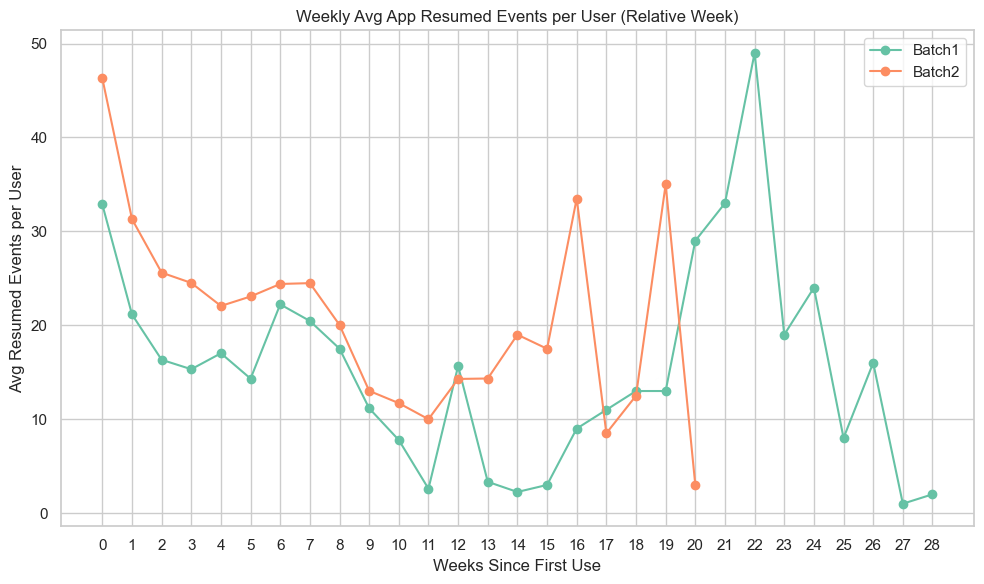

In [142]:
import pandas as pd
import json
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# ─── 기본 설정 ────────────────────────────────────────────────────────────
base_path  = Path("/Users/yooseohyeon/Desktop/170325/eva_250121_processed")
output_dir = Path("./analysis_outputs")
output_dir.mkdir(exist_ok=True, parents=True)
sns.set(style="whitegrid")

# ─── 1) 데이터 불러오기 + 파싱 ─────────────────────────────────────────────
def parse_value(value_str):
    try:
        clean = value_str.replace("'", '"')
        return json.loads(clean)
    except Exception:
        return None

def load_source5_data():
    all_data = []
    # Batch1
    users1 = list((base_path/"Batch1").glob("cmp1_usr*"))
    for user_folder in tqdm(users1, desc="Batch1"):
        uid = int(user_folder.name.replace("cmp1_usr", ""))
        csv = user_folder/"source_5"/"data_source_5.csv"
        if not csv.exists():
            continue
        df = pd.read_csv(csv)
        df["batch"]     = "Batch1"
        df["user_id"]   = uid
        df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
        df["parsed"]    = df["value"].apply(parse_value)
        df["state"]     = df["parsed"].apply(lambda x: x.get("state") if isinstance(x, dict) else None)
        all_data.append(df[["batch","user_id","timestamp","state"]])
    # Batch2
    users2 = list((base_path/"Batch2").glob("cmp1_usr*"))
    for user_folder in tqdm(users2, desc="Batch2"):
        uid = int(user_folder.name.replace("cmp1_usr", ""))
        csv = user_folder/"source_5"/"data_source_5.csv"
        if not csv.exists():
            continue
        df = pd.read_csv(csv)
        df["batch"]     = "Batch2"
        df["user_id"]   = uid
        df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
        df["parsed"]    = df["value"].apply(parse_value)
        df["state"]     = df["parsed"].apply(lambda x: x.get("state") if isinstance(x, dict) else None)
        all_data.append(df[["batch","user_id","timestamp","state"]])
    if all_data:
        df_all = pd.concat(all_data, ignore_index=True)
        print(f"불러온 Source5 데이터 shape: {df_all.shape}")
        return df_all
    else:
        print("Source5 데이터가 없습니다.")
        return pd.DataFrame()

df_app_visibility = load_source5_data()

# ─── 2) 상대 주차 계산 ─────────────────────────────────────────────────────
first_days = (
    df_app_visibility.groupby(["batch","user_id"])["timestamp"]
                    .min()
                    .reset_index(name="first_day")
)
df_app_visibility = df_app_visibility.merge(first_days, on=["batch","user_id"], how="left")
df_app_visibility["week_offset"] = ((df_app_visibility["timestamp"] - df_app_visibility["first_day"]).dt.days // 7).fillna(-1).astype(int)

# ─── 3) 주차별 이벤트 수 & 사용자당 평균 집계 ─────────────────────────────────
# 이벤트 건수
evt = (
    df_app_visibility.groupby(["batch","week_offset","state"])
                     .size()
                     .reset_index(name="total_events")
)
# 고유 사용자 수
users = (
    df_app_visibility.drop_duplicates(["batch","user_id","week_offset"])
                     .groupby(["batch","week_offset"])["user_id"]
                     .nunique()
                     .reset_index(name="unique_users")
)
# 병합 및 평균
weekly = pd.merge(evt, users, on=["batch","week_offset"])
weekly["avg_per_user"] = weekly["total_events"] / weekly["unique_users"]

# ─── 4) 엑셀 저장 ─────────────────────────────────────────────────────────
with pd.ExcelWriter(output_dir/"2.1_AppVisibility_relweek.xlsx") as writer:
    weekly.to_excel(writer, index=False)

# ─── 5) 시각화 (예: resumed) ─────────────────────────────────────────────────
plt.figure(figsize=(10,6))
palette = {"Batch1":"#66C2A5","Batch2":"#FC8D62"}

for batch in ["Batch1","Batch2"]:
    sub = weekly[
        (weekly["batch"]==batch) &
        (weekly["state"]=="AppLifecycleState.resumed")
    ].sort_values("week_offset")
    x = sub["week_offset"]
    y = sub["avg_per_user"]  # 평균 resume 횟수
    plt.plot(x, y, marker="o", label=batch, color=palette[batch])

plt.title("Weekly Avg App Resumed Events per User (Relative Week)")
plt.xlabel("Weeks Since First Use")
plt.ylabel("Avg Resumed Events per User")
plt.legend()
plt.xticks(sorted(weekly["week_offset"].unique()))
plt.tight_layout()
plt.savefig(output_dir/"2.1_AppVisibility_relweek_plot_counts.png")
plt.show()

#### 상태 전이 패턴 분석 (AppLifecycle State Sequences)

총 세션 수: 33420
총 전이 기록 수: 97648


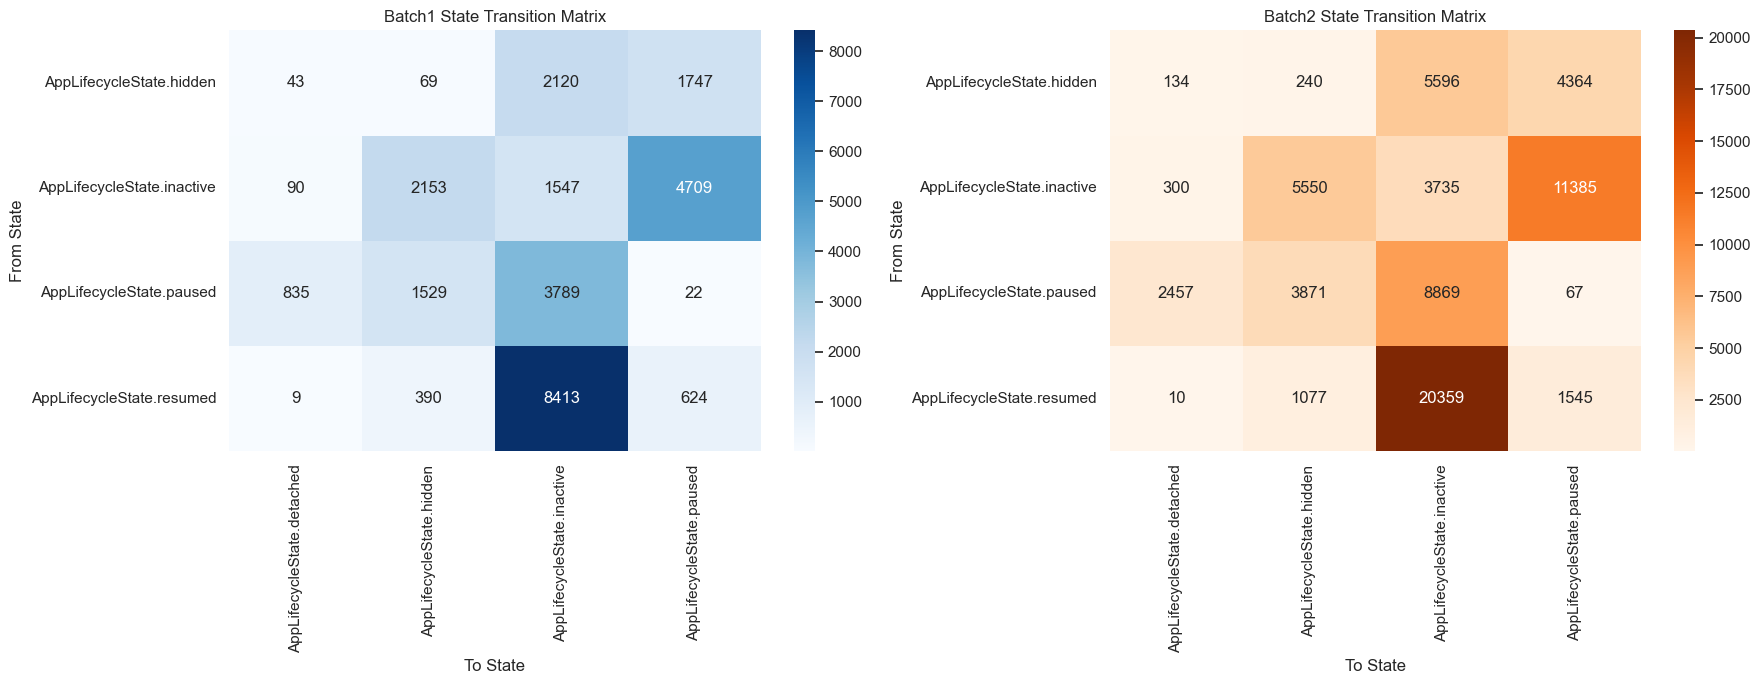

✅ 상태 전이 패턴 분석 + 시각화 완료!


In [13]:
# 📌 상태 전이 패턴 분석 (AppLifecycle State Sequences)
from pathlib import Path
from collections import Counter

# Step 2: 사용자별 세션별 상태 시퀀스 만들기
# 세션 기준: resumed → 다음 inactive/paused/hidden/detached까지

sessions = []

for (batch, user_id), user_data in df_app_visibility.groupby(['batch', 'user_id']):
    user_data = user_data.sort_values('timestamp')
    session = []
    
    for idx, row in user_data.iterrows():
        state = row['state']
        if state == 'AppLifecycleState.resumed':
            if session:
                sessions.append({'batch': batch, 'user_id': user_id, 'sequence': session})
            session = [state]
        else:
            if session:
                session.append(state)
                # detached 나오면 세션 강제 종료
                if state == 'AppLifecycleState.detached':
                    sessions.append({'batch': batch, 'user_id': user_id, 'sequence': session})
                    session = []
    # 마지막 session 저장
    if session:
        sessions.append({'batch': batch, 'user_id': user_id, 'sequence': session})

df_sessions = pd.DataFrame(sessions)
print(f"총 세션 수: {df_sessions.shape[0]}")

# Step 3: 세션별 상태 전이 시퀀스 → 전이 (from → to)로 변환
transition_records = []

for _, row in df_sessions.iterrows():
    batch = row['batch']
    user_id = row['user_id']
    sequence = row['sequence']
    for i in range(len(sequence)-1):
        from_state = sequence[i]
        to_state = sequence[i+1]
        transition_records.append({'batch': batch, 'user_id': user_id, 'from_state': from_state, 'to_state': to_state})

df_transitions = pd.DataFrame(transition_records)
print(f"총 전이 기록 수: {df_transitions.shape[0]}")

# Step 4: 전이 카운트 + Batch별 비교
transition_counts = df_transitions.groupby(['batch', 'from_state', 'to_state']).size().reset_index(name='count')

# Step 5: 전이 행렬 만들기 (Batch1, Batch2 따로)
batch1_matrix = df_transitions[df_transitions['batch'] == 'Batch1'].groupby(['from_state', 'to_state']).size().unstack(fill_value=0)
batch2_matrix = df_transitions[df_transitions['batch'] == 'Batch2'].groupby(['from_state', 'to_state']).size().unstack(fill_value=0)

# Step 6: 전이 행렬 시각화
fig, axs = plt.subplots(1, 2, figsize=(18, 7))

sns.heatmap(batch1_matrix, annot=True, fmt='d', cmap="Blues", ax=axs[0])
axs[0].set_title('Batch1 State Transition Matrix')
axs[0].set_xlabel('To State')
axs[0].set_ylabel('From State')

sns.heatmap(batch2_matrix, annot=True, fmt='d', cmap="Oranges", ax=axs[1])
axs[1].set_title('Batch2 State Transition Matrix')
axs[1].set_xlabel('To State')
axs[1].set_ylabel('From State')

plt.tight_layout()
plt.savefig(output_dir / "2.1_AppVisibility_상태전이_히트맵비교.png")
plt.show()

# Step 7: 결과 저장
with pd.ExcelWriter(output_dir / "2.1_AppVisibility_상태전이패턴_전체.xlsx") as writer:
    df_sessions.to_excel(writer, sheet_name='Sessions', index=False)
    df_transitions.to_excel(writer, sheet_name='Transitions', index=False)
    batch1_matrix.to_excel(writer, sheet_name='Batch1_Matrix')
    batch2_matrix.to_excel(writer, sheet_name='Batch2_Matrix')

print("✅ 상태 전이 패턴 분석 + 시각화 완료!")

#### 세션 단위 포그라운드/백그라운드 체류시간 수명주기 분석

세션 수: 33420
요약 세션 수: 33420


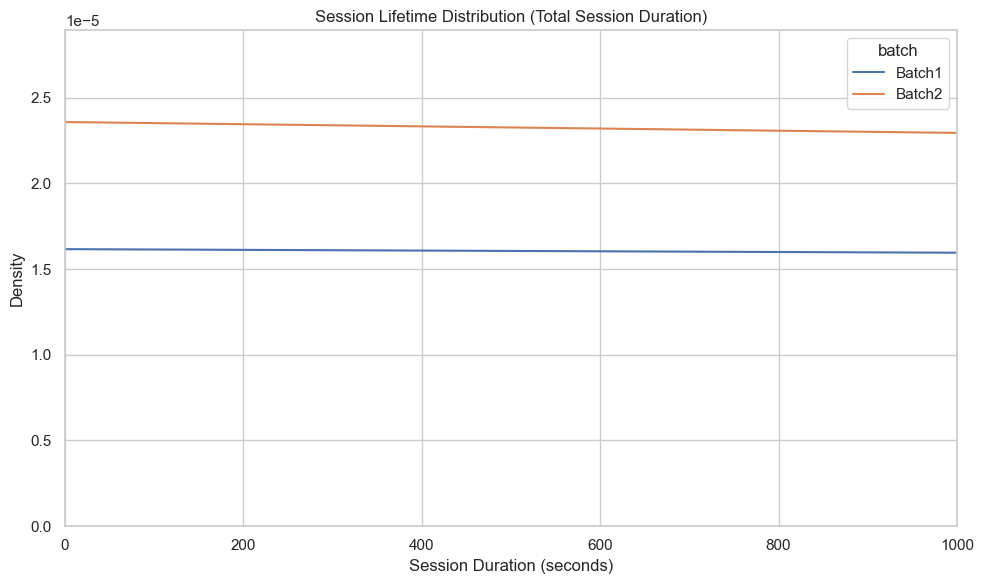

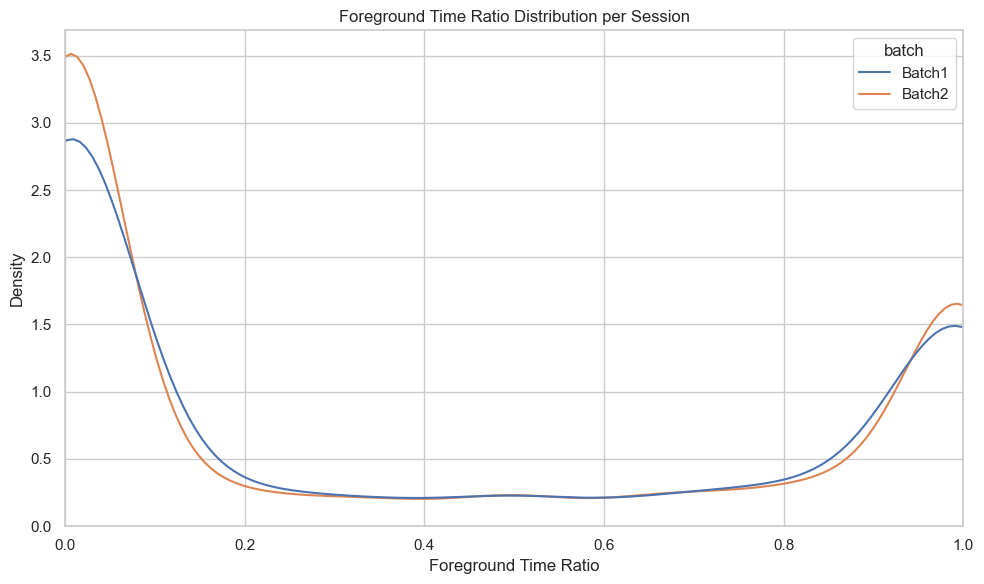

✅ 세션 단위 체류 시간/수명주기 분석 + 시각화 완료!


In [14]:
# 📌 세션 단위 포그라운드/백그라운드 체류시간 수명주기 분석
# Step 2: 세션 나누기 (resumed 상태를 기준으로 세션 구분)
sessions = []
session_id = 0

for (batch, user_id), user_data in df_app_visibility.groupby(['batch', 'user_id']):
    user_data = user_data.sort_values('timestamp')
    session = []
    
    for idx, row in user_data.iterrows():
        state = row['state']
        timestamp = row['timestamp']
        
        if state == 'AppLifecycleState.resumed':
            if session:
                sessions.append({'batch': batch, 'user_id': user_id, 'session_id': session_id, 'events': session})
                session_id += 1
            session = [(state, timestamp)]
        else:
            if session:
                session.append((state, timestamp))
                if state == 'AppLifecycleState.detached':
                    sessions.append({'batch': batch, 'user_id': user_id, 'session_id': session_id, 'events': session})
                    session_id += 1
                    session = []
    if session:
        sessions.append({'batch': batch, 'user_id': user_id, 'session_id': session_id, 'events': session})
        session_id += 1

print(f"세션 수: {len(sessions)}")

# Step 3: 세션별 포그라운드/백그라운드 체류 시간 계산
session_summaries = []

for sess in sessions:
    batch = sess['batch']
    user_id = sess['user_id']
    session_id = sess['session_id']
    events = sess['events']
    
    fg_time = 0
    bg_time = 0
    total_time = 0
    
    for i in range(len(events)-1):
        state, time = events[i]
        next_state, next_time = events[i+1]
        duration = (next_time - time).total_seconds()
        total_time += duration
        
        if state == 'AppLifecycleState.resumed':
            fg_time += duration
        elif state in ['AppLifecycleState.inactive', 'AppLifecycleState.paused', 'AppLifecycleState.hidden']:
            bg_time += duration
    
    session_summaries.append({
        'batch': batch,
        'user_id': user_id,
        'session_id': session_id,
        'total_session_time': total_time,
        'foreground_time': fg_time,
        'background_time': bg_time
    })

df_sessions = pd.DataFrame(session_summaries)
print(f"요약 세션 수: {df_sessions.shape[0]}")

# Step 4: 시각화 (1) 세션 총 길이 분포
plt.figure(figsize=(10,6))
sns.kdeplot(data=df_sessions, x='total_session_time', hue='batch', common_norm=False)
plt.title('Session Lifetime Distribution (Total Session Duration)')
plt.xlabel('Session Duration (seconds)')
plt.ylabel('Density')
plt.xlim(0, 1000)  # 주로 짧은 세션 포커스
plt.tight_layout()
plt.savefig(output_dir / "2.1_AppVisibility_세션_수명주기_총길이분포.png")
plt.show()

# Step 5: 시각화 (2) 포그라운드 vs 백그라운드 비율 분포
df_sessions['foreground_ratio'] = df_sessions['foreground_time'] / df_sessions['total_session_time']
df_sessions['background_ratio'] = df_sessions['background_time'] / df_sessions['total_session_time']

plt.figure(figsize=(10,6))
sns.kdeplot(data=df_sessions, x='foreground_ratio', hue='batch', common_norm=False)
plt.title('Foreground Time Ratio Distribution per Session')
plt.xlabel('Foreground Time Ratio')
plt.ylabel('Density')
plt.xlim(0, 1)
plt.tight_layout()
plt.savefig(output_dir / "2.1_AppVisibility_세션_포그라운드비율분포.png")
plt.show()

# Step 6: 결과 저장
df_sessions.to_excel(output_dir / "2.1_AppVisibility_세션_포그라운드백그라운드요약.xlsx", index=False)

print("✅ 세션 단위 체류 시간/수명주기 분석 + 시각화 완료!")

#### 시간 흐름에 따른 상태 전환량 감소 분석 (Source5)

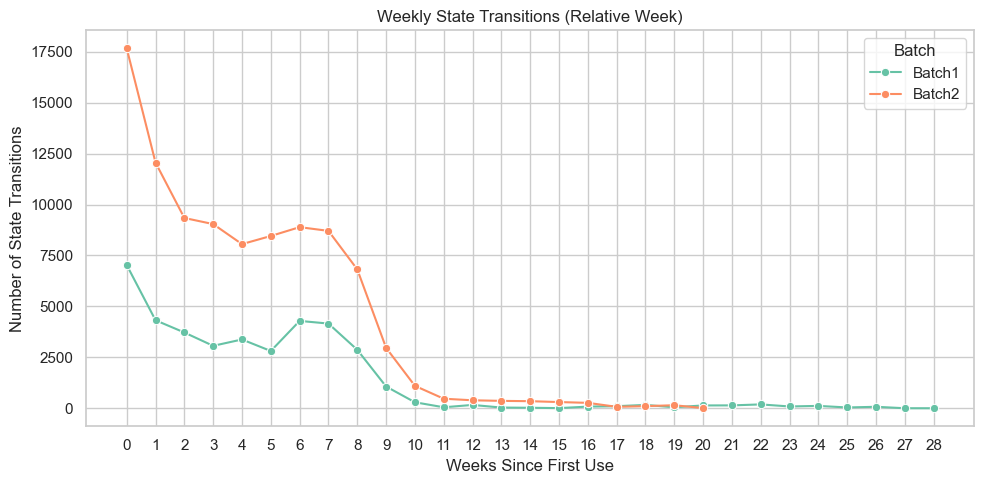

✅ 상대 주차 기준 상태 전환량 분석 및 시각화 완료!


In [31]:
# ─── 0) 준비: 필요한 모듈 임포트 ─────────────────────────────────────────────
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set(style="whitegrid")

# output_dir 는 기존에 정의된 경로
# df_app_visibility 는 이전에 로드된 Source5 데이터프레임

# ─── 1) 사용자별 첫 사용일 계산 ─────────────────────────────────────────────
first_use = (
    df_app_visibility
      .groupby(['batch', 'user_id'])['timestamp']
      .min()
      .reset_index()
      .rename(columns={'timestamp':'first_use'})
)
df_app_visibility = df_app_visibility.merge(first_use, on=['batch','user_id'])

# ─── 2) 상대 주차(week_offset) 계산 ─────────────────────────────────────────
df_app_visibility['day_offset'] = (
    df_app_visibility['timestamp'] - df_app_visibility['first_use']
).dt.days
df_app_visibility['week_offset'] = (df_app_visibility['day_offset'] // 7).astype(int)

# ─── 3) 상태 전환 플래그 만들기 ─────────────────────────────────────────────
df_app_visibility['prev_state'] = (
    df_app_visibility
      .sort_values(['batch','user_id','timestamp'])
      .groupby(['batch','user_id'])['state']
      .shift(1)
)
df_app_visibility['is_transition'] = (
    df_app_visibility['state'] != df_app_visibility['prev_state']
)
# 첫 이벤트(shift 결과가 NaN)나 state 동일 행은 제외
df_transitions = df_app_visibility[df_app_visibility['is_transition'] & df_app_visibility['prev_state'].notna()]

# ─── 4) 주차별 전환량 집계 ─────────────────────────────────────────────────
weekly_transition = (
    df_transitions
      .groupby(['batch','week_offset'])
      .size()
      .reset_index(name='transition_count')
)

# ─── 5) 시각화: 상대 주차 상대 전환량 ─────────────────────────────────────
plt.figure(figsize=(10,5))
sns.lineplot(
    data=weekly_transition,
    x='week_offset', y='transition_count',
    hue='batch', marker='o', palette='Set2'
)
plt.title('Weekly State Transitions (Relative Week)')
plt.xlabel('Weeks Since First Use')
plt.ylabel('Number of State Transitions')
plt.xticks(sorted(weekly_transition['week_offset'].unique()))
plt.legend(title='Batch')
plt.tight_layout()
plt.savefig(output_dir/"2.1_AppVisibility_relativeWeek_transitions.png")
plt.show()

# ─── 6) 엑셀로 저장 ───────────────────────────────────────────────────────
weekly_transition.to_excel(
    output_dir/"2.1_AppVisibility_relativeWeek_transitions.xlsx",
    index=False
)
print("✅ 상대 주차 기준 상태 전환량 분석 및 시각화 완료!")

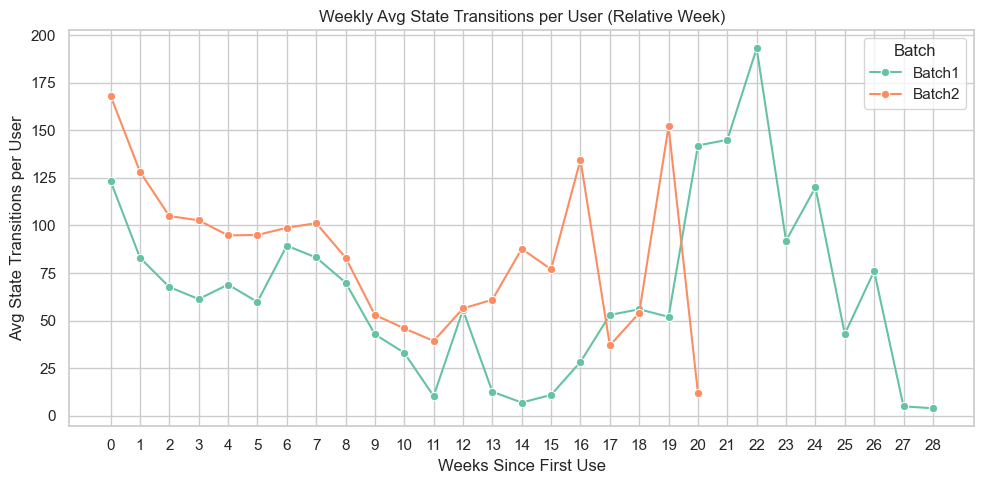

In [103]:
# ─── 4) 주차별 전환량 집계 → 평균 전환량 계산으로 변경 ────────────────────────
weekly_transition = (
    df_transitions
      .groupby(['batch','week_offset'])
      .agg(
        total_transitions=('state','size'),
        unique_users       =('user_id','nunique')
      )
      .reset_index()
)
weekly_transition['avg_transitions_per_user'] = (
    weekly_transition['total_transitions'] 
    / weekly_transition['unique_users']
)

# ─── 5) 시각화: 평균 전환량으로 변경 ─────────────────────────────────────
plt.figure(figsize=(10,5))
sns.lineplot(
    data=weekly_transition,
    x='week_offset', y='avg_transitions_per_user',
    hue='batch', marker='o', palette='Set2'
)
plt.title('Weekly Avg State Transitions per User (Relative Week)')
plt.xlabel('Weeks Since First Use')
plt.ylabel('Avg State Transitions per User')
plt.xticks(sorted(weekly_transition['week_offset'].unique()))
plt.legend(title='Batch')
plt.tight_layout()
plt.savefig(output_dir/"2.1_AppVisibility_relativeWeek_avgTransitions.png")
plt.show()

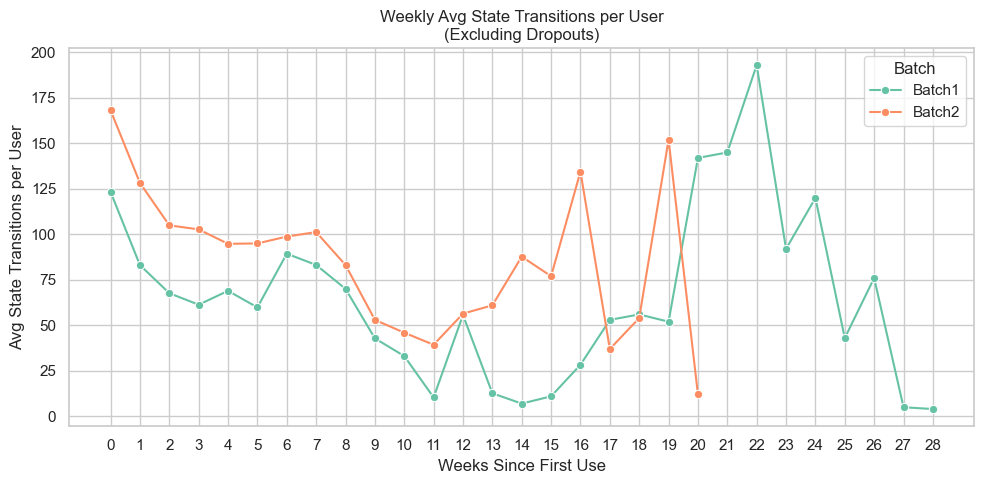

In [33]:
# ─── 0) Dropout 사용자 리스트 정의 ─────────────────────────────────────────
drop_batch1 = [542,584,597,601,608,613,617,618,621,631,639,645]
drop_batch2 = [662,663,666,669,682,683,689,701,704,716,723,725,726,727,736,746,756,765,767,769]
dropouts = {f"cmp1_usr{u}" for u in drop_batch1 + drop_batch2}

# ─── (이전 코드) df_transitions 생성 후 ────────────────────────────────────
# df_transitions = … 

# ─── 4-1) Dropout 사용자 제외 ─────────────────────────────────────────────
df_transitions = df_transitions[~df_transitions['user_id'].isin(dropouts)]

# ─── 4-2) 주차별 전환량 집계 → 사용자당 평균 전환량 계산 ────────────────────
weekly_transition = (
    df_transitions
      .groupby(['batch','week_offset'])
      .agg(
        total_transitions=('state','size'),
        unique_users       =('user_id','nunique')
      )
      .reset_index()
)
weekly_transition['avg_transitions_per_user'] = (
    weekly_transition['total_transitions'] 
    / weekly_transition['unique_users']
)

# ─── 5) 시각화: 평균 전환량 ───────────────────────────────────────────────
plt.figure(figsize=(10,5))
sns.lineplot(
    data=weekly_transition,
    x='week_offset', y='avg_transitions_per_user',
    hue='batch', marker='o', palette='Set2'
)
plt.title('Weekly Avg State Transitions per User\n(Excluding Dropouts)')
plt.xlabel('Weeks Since First Use')
plt.ylabel('Avg State Transitions per User')
plt.xticks(sorted(weekly_transition['week_offset'].unique()))
plt.legend(title='Batch')
plt.tight_layout()
plt.savefig(output_dir/"2.1_AppVisibility_avgTrans_exclDropouts.png")
plt.show()

/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_41051/16313194.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


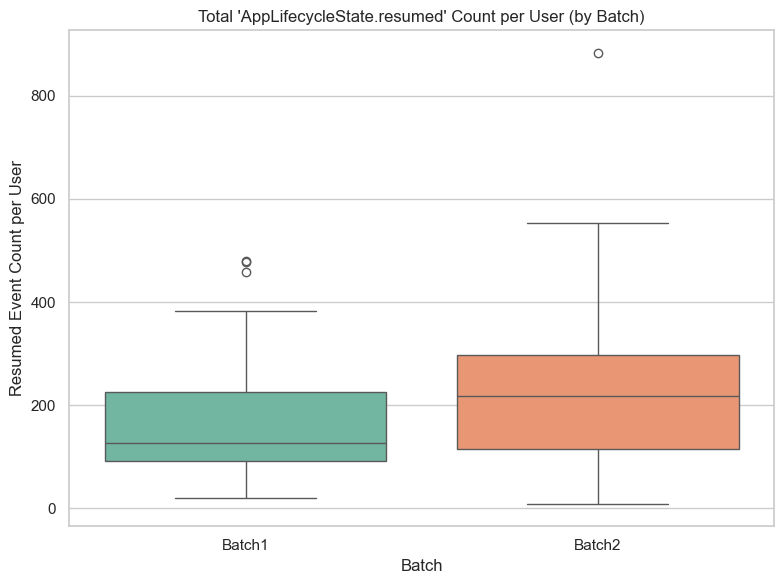

        count    mean     std   min    25%    50%    75%    max
batch                                                          
Batch1   58.0  166.67  111.05  20.0   92.5  127.5  225.5  480.0
Batch2  105.0  224.73  144.30   9.0  115.0  218.0  298.0  883.0


In [121]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# AppLifecycleState.resumed만 필터링
resumed_df = df_transitions[df_transitions["state"] == "AppLifecycleState.resumed"]

# 사용자별 resumed 총 이벤트 수 계산
user_resumed_counts = (
    resumed_df
    .groupby(["batch", "user_id"])
    .size()
    .reset_index(name="resumed_count")
)

# Boxplot 시각화
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=user_resumed_counts,
    x="batch",
    y="resumed_count",
    palette="Set2"
)
plt.title("Total 'AppLifecycleState.resumed' Count per User (by Batch)")
plt.xlabel("Batch")
plt.ylabel("Resumed Event Count per User")
plt.tight_layout()
plt.show()
# 평균, 중앙값, 표준편차 등 배치별로 집계
stats = (
    user_resumed_counts
    .groupby("batch")["resumed_count"]
    .describe()
    .round(2)  # 보기 좋게 소수점 2자리로
)

print(stats)

Loading Source5 Batch2: 100%|██████████| 108/108 [00:00<00:00, 304.13it/s]
/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_41051/1827522703.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered, x="batch", y="evapp_focus_ratio", palette="Set2")


        count      mean       std       min       25%       50%       75%  \
batch                                                                       
Batch1   54.0  0.298583  0.835654  0.018167  0.073603  0.129826  0.270011   
Batch2  101.0  0.438453  1.021701  0.017832  0.101785  0.155678  0.319507   

             max  
batch             
Batch1  6.176471  
Batch2  6.181818  


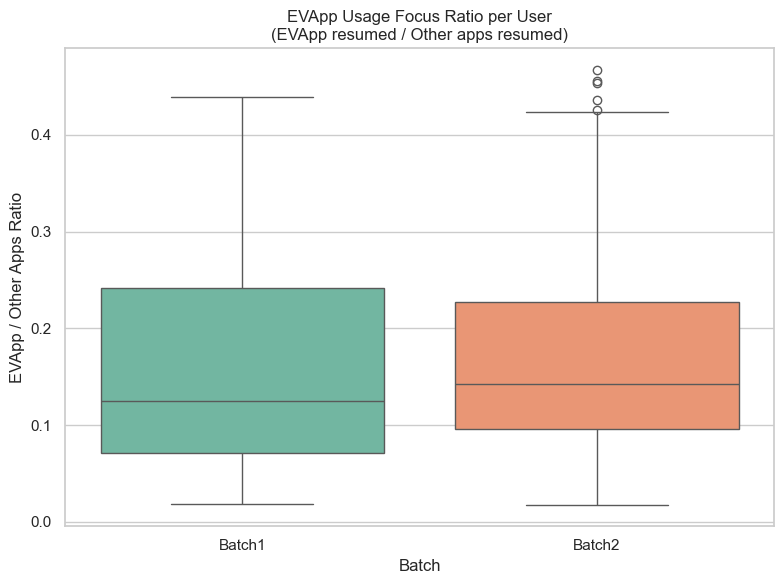

In [136]:
# source_20 데이터 불러오기
def load_source20_data():
    all_data = []
    for batch in ["Batch1", "Batch2"]:
        user_dirs = list((base_path / batch).glob("cmp1_usr*"))
        for user_dir in tqdm(user_dirs, desc=f"Loading {batch}"):
            user_id = int(user_dir.name.replace("cmp1_usr", ""))
            file_path = user_dir / "source_20" / "data_source_20.csv"
            if not file_path.exists():
                continue
            df = pd.read_csv(file_path)
            df["parsed"] = df["value"].apply(parse_value)
            df["activityType"] = df["parsed"].apply(lambda x: x.get("activityType") if isinstance(x, dict) else None)
            df["event_ts"] = pd.to_datetime(df["parsed"].apply(lambda x: x.get("timestamp") if isinstance(x, dict) else None))
            df["batch"] = batch
            df["user_id"] = user_id
            all_data.append(df[["batch", "user_id", "event_ts", "activityType"]])
    return pd.concat(all_data, ignore_index=True)

source20_df = load_source20_data()

# 전체 resumed 이벤트 수 (source_20)
total_resumed = (
    source20_df[source20_df["activityType"] == "ACTIVITY_RESUMED - 1"]
    .groupby(["batch", "user_id"])
    .size()
    .reset_index(name="total_resumed")
)

# EVApp resumed 수 (source_5)
evapp_df = load_source5_data()  # 기존 함수 그대로 사용

evapp_resumed = (
    evapp_df[evapp_df["state"] == "AppLifecycleState.resumed"]
    .groupby(["batch", "user_id"])
    .size()
    .reset_index(name="evapp_resumed")
)
# 양쪽 모두 user_id를 정수형으로 맞춤
total_resumed["user_id"] = total_resumed["user_id"].astype(int)
evapp_resumed["user_id"] = evapp_resumed["user_id"].astype(int)
merged_df = pd.merge(total_resumed, evapp_resumed, on=["batch", "user_id"], how="left").fillna(0)
merged_df["evapp_focus_ratio"] = merged_df["evapp_resumed"] / merged_df["total_resumed"]
print(merged_df.groupby("batch")["evapp_focus_ratio"].describe())
filtered = merged_df[merged_df["evapp_focus_ratio"] <= 0.5]  # 비정상적으로 높은 값 제거

plt.figure(figsize=(8, 6))
sns.boxplot(data=filtered, x="batch", y="evapp_focus_ratio", palette="Set2")
plt.title("EVApp Usage Focus Ratio per User\n(EVApp resumed / Other apps resumed)")
plt.ylabel("EVApp / Other Apps Ratio")
plt.xlabel("Batch")
plt.tight_layout()
plt.savefig(output_dir / "boxplot_evapp_usage_ratio_by_batch.png")
plt.show()

In [138]:
import scipy.stats as stats

# ── 1) 두 그룹 데이터 추출 ───────────────────────────────────────────────
b1 = filtered[filtered["batch"] == "Batch1"]["evapp_focus_ratio"]
b2 = filtered[filtered["batch"] == "Batch2"]["evapp_focus_ratio"]

# ── 2) 정규성 검사 (Shapiro–Wilk) ──────────────────────────────────────
shapiro1 = stats.shapiro(b1)
shapiro2 = stats.shapiro(b2)
print(f"Shapiro Batch1: W={shapiro1.statistic:.3f}, p={shapiro1.pvalue:.3e}")
print(f"Shapiro Batch2: W={shapiro2.statistic:.3f}, p={shapiro2.pvalue:.3e}")

# ── 3) 등분산성 검사 (Levene) ──────────────────────────────────────────
levene = stats.levene(b1, b2)
print(f"Levene test: W={levene.statistic:.3f}, p={levene.pvalue:.3f}")

# ── 4) Welch’s t-test (등분산 가정 무관) ────────────────────────────────
t_res = stats.ttest_ind(b1, b2, equal_var=False)
print(f"Welch’s t-test: t={t_res.statistic:.3f}, p={t_res.pvalue:.3f}")

# ── 5) Mann–Whitney U test (비모수) ─────────────────────────────────────
mw = stats.mannwhitneyu(b1, b2, alternative="two-sided")
print(f"Mann–Whitney U: U={mw.statistic:.1f}, p={mw.pvalue:.3f}")

import numpy as np

# 그룹별 표본 크기
n1 = len(b1)
n2 = len(b2)

# 그룹별 분산
s1_sq = np.var(b1, ddof=1)
s2_sq = np.var(b2, ddof=1)

# Welch 자유도 계산
numerator = (s1_sq / n1 + s2_sq / n2) ** 2
denominator = ( (s1_sq**2) / (n1**2 * (n1 - 1)) ) + ( (s2_sq**2) / (n2**2 * (n2 - 1)) )
df_welch = numerator / denominator

print(f"Welch 자유도: {df_welch:.2f}")

Shapiro Batch1: W=0.881, p=9.119e-05
Shapiro Batch2: W=0.881, p=7.856e-07
Levene test: W=0.583, p=0.446
Welch’s t-test: t=-0.359, p=0.720
Mann–Whitney U: U=2088.0, p=0.390
Welch 자유도: 100.44


Loading Source5 Batch2: 100%|██████████| 108/108 [00:00<00:00, 336.28it/s]
/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_41051/345047028.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered, x="batch", y="evapp_unlock_ratio", palette="Set2")


        count      mean       std      min       25%       50%       75%  \
batch                                                                      
Batch1   59.0  0.081981  0.127503  0.00000  0.021062  0.043712  0.096638   
Batch2  105.0  0.224883  0.869945  0.01628  0.041856  0.067756  0.117647   

             max  
batch             
Batch1  0.720339  
Batch2  8.333333  


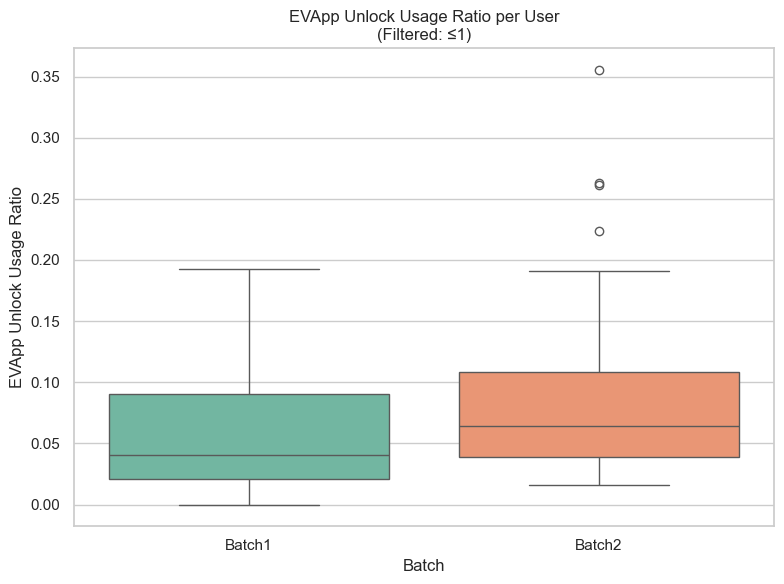

In [133]:
import pandas as pd
import json
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# ─── 설정 ──────────────────────────────────────
base_path = Path("/Users/yooseohyeon/Desktop/170325/eva_250121_processed")
sns.set(style="whitegrid")

# ─── JSON 파싱 함수 ─────────────────────────────
def parse_value(value_str):
    try:
        return json.loads(value_str.replace("'", '"'))
    except:
        return None

# ─── source_3: 스마트폰 Unlock 데이터 ─────────────
def load_source3_data():
    all_data = []
    for batch in ["Batch1", "Batch2"]:
        user_dirs = list((base_path / batch).glob("cmp1_usr*"))
        for user_dir in tqdm(user_dirs, desc=f"Loading Source3 {batch}"):
            user_id = user_dir.name.replace("cmp1_usr", "")
            file_path = user_dir / "source_3" / "data_source_3.csv"
            if not file_path.exists():
                continue
            df = pd.read_csv(file_path)
            df["parsed"] = df["value"].apply(parse_value)
            df["state"] = df["parsed"].apply(lambda x: x.get("state") if isinstance(x, dict) else None)
            df["batch"] = batch
            df["user_id"] = user_id
            all_data.append(df[["batch", "user_id", "state"]])
    return pd.concat(all_data, ignore_index=True)

source3_df = load_source3_data()

unlock_counts = (
    source3_df[source3_df["state"] == "ScreenStateEvent.SCREEN_UNLOCKED"]
    .groupby(["batch", "user_id"])
    .size()
    .reset_index(name="unlock_count")
)

# ─── source_5: EVApp resumed 횟수 ────────────────
def load_source5_data():
    all_data = []
    for batch in ["Batch1", "Batch2"]:
        user_dirs = list((base_path / batch).glob("cmp1_usr*"))
        for user_dir in tqdm(user_dirs, desc=f"Loading Source5 {batch}"):
            user_id = user_dir.name.replace("cmp1_usr", "")
            file_path = user_dir / "source_5" / "data_source_5.csv"
            if not file_path.exists():
                continue
            df = pd.read_csv(file_path)
            df["parsed"] = df["value"].apply(parse_value)
            df["state"] = df["parsed"].apply(lambda x: x.get("state") if isinstance(x, dict) else None)
            df["batch"] = batch
            df["user_id"] = user_id
            all_data.append(df[["batch", "user_id", "state"]])
    return pd.concat(all_data, ignore_index=True)

source5_df = load_source5_data()

evapp_resumed_counts = (
    source5_df[source5_df["state"] == "AppLifecycleState.resumed"]
    .groupby(["batch", "user_id"])
    .size()
    .reset_index(name="evapp_resumed")
)

# ─── Merge & Ratio 계산 ─────────────────────────
merged_df = pd.merge(unlock_counts, evapp_resumed_counts, on=["batch", "user_id"], how="left").fillna(0)
merged_df["evapp_unlock_ratio"] = merged_df["evapp_resumed"] / merged_df["unlock_count"]
print(merged_df.groupby("batch")["evapp_unlock_ratio"].describe())
# ─── 시각화 ──────────────────────────────────────
filtered = merged_df[merged_df["evapp_unlock_ratio"] <= 0.5]  # 비정상적으로 높은 값 제거

plt.figure(figsize=(8, 6))
sns.boxplot(data=filtered, x="batch", y="evapp_unlock_ratio", palette="Set2")
plt.title("EVApp Unlock Usage Ratio per User\n(Filtered: ≤1)")
plt.xlabel("Batch")
plt.ylabel("EVApp Unlock Usage Ratio")
plt.tight_layout()
plt.show()

In [134]:
import scipy.stats as stats

# ── 1) 두 그룹 데이터 추출 ───────────────────────────────────────────────
b1 = filtered[filtered["batch"] == "Batch1"]["evapp_unlock_ratio"]
b2 = filtered[filtered["batch"] == "Batch2"]["evapp_unlock_ratio"]

# ── 2) 정규성 검사 (Shapiro–Wilk) ──────────────────────────────────────
shapiro1 = stats.shapiro(b1)
shapiro2 = stats.shapiro(b2)
print(f"Shapiro Batch1: W={shapiro1.statistic:.3f}, p={shapiro1.pvalue:.3e}")
print(f"Shapiro Batch2: W={shapiro2.statistic:.3f}, p={shapiro2.pvalue:.3e}")

# ── 3) 등분산성 검사 (Levene) ──────────────────────────────────────────
levene = stats.levene(b1, b2)
print(f"Levene test: W={levene.statistic:.3f}, p={levene.pvalue:.3f}")

# ── 4) Welch’s t-test (등분산 가정 무관) ────────────────────────────────
t_res = stats.ttest_ind(b1, b2, equal_var=False)
print(f"Welch’s t-test: t={t_res.statistic:.3f}, p={t_res.pvalue:.3f}")

# ── 5) Mann–Whitney U test (비모수) ─────────────────────────────────────
mw = stats.mannwhitneyu(b1, b2, alternative="two-sided")
print(f"Mann–Whitney U: U={mw.statistic:.1f}, p={mw.pvalue:.3f}")

Shapiro Batch1: W=0.867, p=1.522e-05
Shapiro Batch2: W=0.836, p=4.677e-09
Levene test: W=0.188, p=0.665
Welch’s t-test: t=-2.425, p=0.017
Mann–Whitney U: U=2023.0, p=0.004


In [135]:
import numpy as np

# 그룹별 표본 크기
n1 = len(b1)
n2 = len(b2)

# 그룹별 분산
s1_sq = np.var(b1, ddof=1)
s2_sq = np.var(b2, ddof=1)

# Welch 자유도 계산
numerator = (s1_sq / n1 + s2_sq / n2) ** 2
denominator = ( (s1_sq**2) / (n1**2 * (n1 - 1)) ) + ( (s2_sq**2) / (n2**2 * (n2 - 1)) )
df_welch = numerator / denominator

print(f"Welch 자유도: {df_welch:.2f}")

Welch 자유도: 135.57


#### Detached (앱 종료) 이벤트 집중 분석 (Source5)

✔️ 불러온 Source5 데이터: (134998, 6)
✔️ first_days sample:
     batch  user_id           first_day
0  Batch1      541 2024-11-06 16:01:57
1  Batch1      545 2024-11-11 21:03:56
2  Batch1      546 2024-11-06 14:33:33
3  Batch1      547 2024-11-18 14:53:53
4  Batch1      559 2024-11-06 16:53:07
✔️ Detached 이벤트 총개수: 3892
✔️ weekly_detached sample:
     batch  week_offset  detached_count
0  Batch1            0             137
1  Batch1            1             102
2  Batch1            2             119
3  Batch1            3             112
4  Batch1            4             101


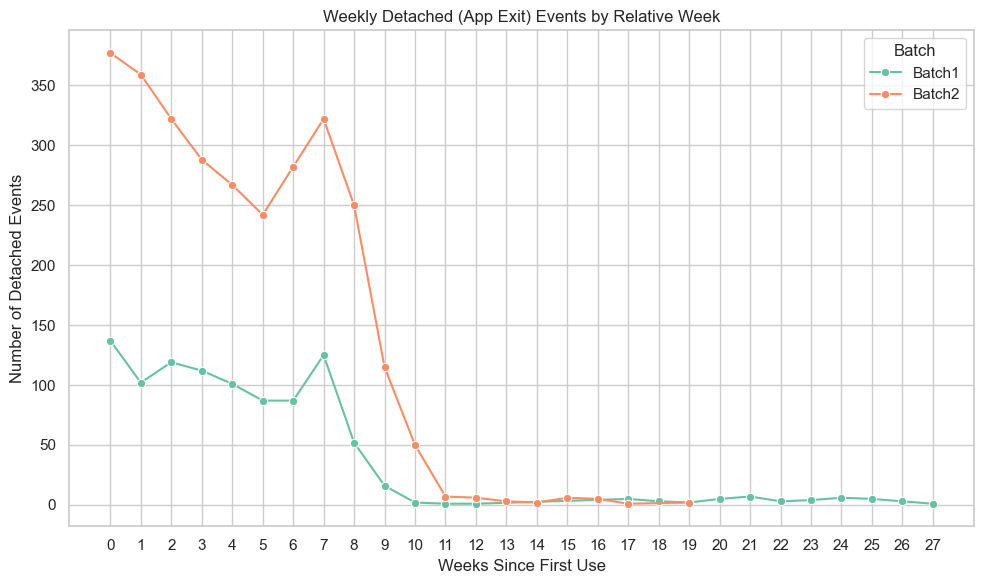

✅ 완료: Detached 이벤트의 상대 주차별 분석 및 시각화


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import json

# ─── (1) Source5 데이터 불러오기 ─────────────────────────────────────────────
def parse_value(value_str):
    try:
        clean = value_str.replace("'", '"')
        return json.loads(clean)
    except:
        return None

def load_source5_data(base_path):
    all_data = []
    for batch in ['Batch1','Batch2']:
        for uf in (base_path/batch).glob('cmp1_usr*'):
            user_id = uf.name.replace('cmp1_usr','')
            csv_file = uf/'source_5'/'data_source_5.csv'
            if not csv_file.exists():
                continue
            df = pd.read_csv(csv_file)
            if df.empty or 'timestamp' not in df.columns or 'value' not in df.columns:
                continue
            df = df[['timestamp','value']].copy()
            df['batch']   = batch
            df['user_id'] = int(user_id)
            all_data.append(df)
    if not all_data:
        return pd.DataFrame()
    df = pd.concat(all_data, ignore_index=True)
    # 파싱
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df['parsed']    = df['value'].apply(parse_value)
    df['state']     = df['parsed'].apply(lambda x: x.get('state') if isinstance(x,dict) else None)
    return df.dropna(subset=['timestamp','state'])

# ─── (2) 불러오기 ────────────────────────────────────────────────────────────
base_path          = Path("/Users/yooseohyeon/Desktop/170325/eva_250121_processed")
output_dir         = Path("./analysis_outputs")
output_dir.mkdir(exist_ok=True)
df_app_visibility  = load_source5_data(base_path)
print(f"✔️ 불러온 Source5 데이터: {df_app_visibility.shape}")

# ─── (3) 사용자별 첫 사용일 계산 ─────────────────────────────────────────────
first_days = (
    df_app_visibility
      .groupby(['batch','user_id'])['timestamp']
      .min()
      .reset_index(name='first_day')
)
print("✔️ first_days sample:\n", first_days.head())

# ─── (4) 병합 & week_offset 추가 ─────────────────────────────────────────────
df_app_visibility = df_app_visibility.merge(
    first_days, on=['batch','user_id'], how='left'
)
df_app_visibility['week_offset'] = (
    (df_app_visibility['timestamp'] - df_app_visibility['first_day'])
     .dt.days // 7
).astype(int)

# ─── (5) Detached 이벤트만 필터링 ───────────────────────────────────────────
df_det = df_app_visibility[df_app_visibility['state']=='AppLifecycleState.detached'].copy()
print(f"✔️ Detached 이벤트 총개수: {len(df_det)}")

# ─── (6) 상대 주차별 Detached 이벤트 집계 ──────────────────────────────────
weekly_detached = (
    df_det
      .groupby(['batch','week_offset'])
      .size()
      .reset_index(name='detached_count')
)
print("✔️ weekly_detached sample:\n", weekly_detached.head())

# ─── (7) 시각화 ───────────────────────────────────────────────────────────
sns.set(style="whitegrid")
plt.figure(figsize=(10,6))
sns.lineplot(
    data=weekly_detached,
    x='week_offset', y='detached_count',
    hue='batch', marker='o', palette='Set2'
)
plt.title('Weekly Detached (App Exit) Events by Relative Week')
plt.xlabel('Weeks Since First Use')
plt.ylabel('Number of Detached Events')
plt.xticks(sorted(weekly_detached['week_offset'].unique()))
plt.legend(title='Batch')
plt.tight_layout()
plt.savefig(output_dir/"2.1_AppVisibility_WeeklyDetached_RelativeWeek.png")
plt.show()

# ─── (8) 결과 저장 ────────────────────────────────────────────────────────
weekly_detached.to_excel(
    output_dir/"2.1_AppVisibility_WeeklyDetached_RelativeWeek.xlsx",
    index=False
)
print("✅ 완료: Detached 이벤트의 상대 주차별 분석 및 시각화")

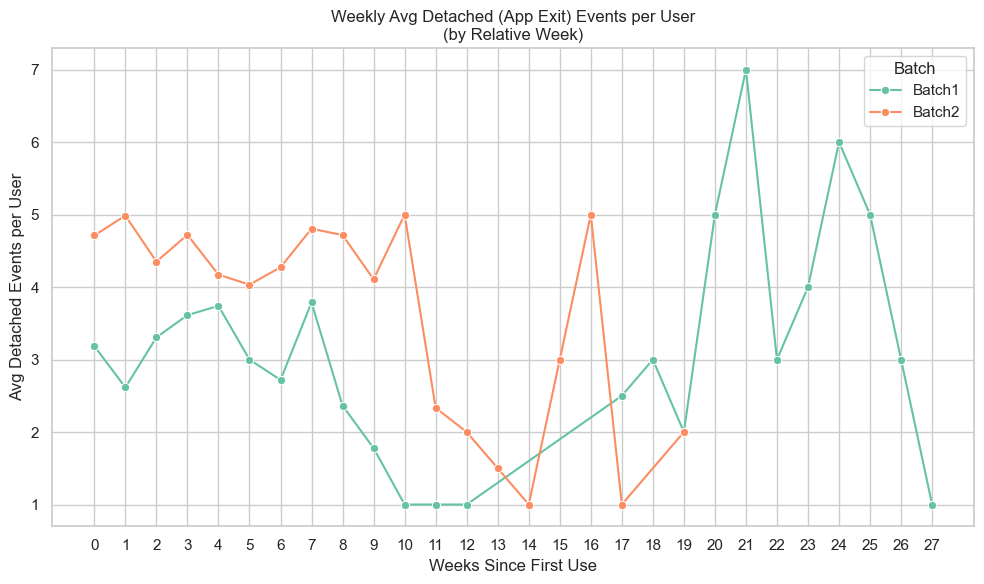

In [34]:
# ─── (6) 상대 주차별 Detached 이벤트 집계 → 평균 계산으로 변경 ─────────────────
weekly_detached = (
    df_det
      .groupby(['batch','week_offset'])
      .agg(
          total_detached=('state','size'),
          unique_users   =('user_id','nunique')
      )
      .reset_index()
)
weekly_detached['avg_detached_per_user'] = (
    weekly_detached['total_detached']
    / weekly_detached['unique_users']
)

# ─── (7) 시각화: 평균 종료 이벤트 수 ─────────────────────────────────────────
plt.figure(figsize=(10,6))
sns.lineplot(
    data=weekly_detached,
    x='week_offset', y='avg_detached_per_user',
    hue='batch', marker='o', palette='Set2'
)
plt.title('Weekly Avg Detached (App Exit) Events per User\n(by Relative Week)')
plt.xlabel('Weeks Since First Use')
plt.ylabel('Avg Detached Events per User')
plt.xticks(sorted(weekly_detached['week_offset'].unique()))
plt.legend(title='Batch')
plt.tight_layout()
plt.savefig(output_dir/"2.1_AppVisibility_WeeklyDetached_AvgPerUser.png")
plt.show()

# ─── (8) 결과 저장 ─────────────────────────────────────────────────────────
weekly_detached.to_excel(
    output_dir/"2.1_AppVisibility_WeeklyDetached_AvgPerUser.xlsx",
    index=False
)

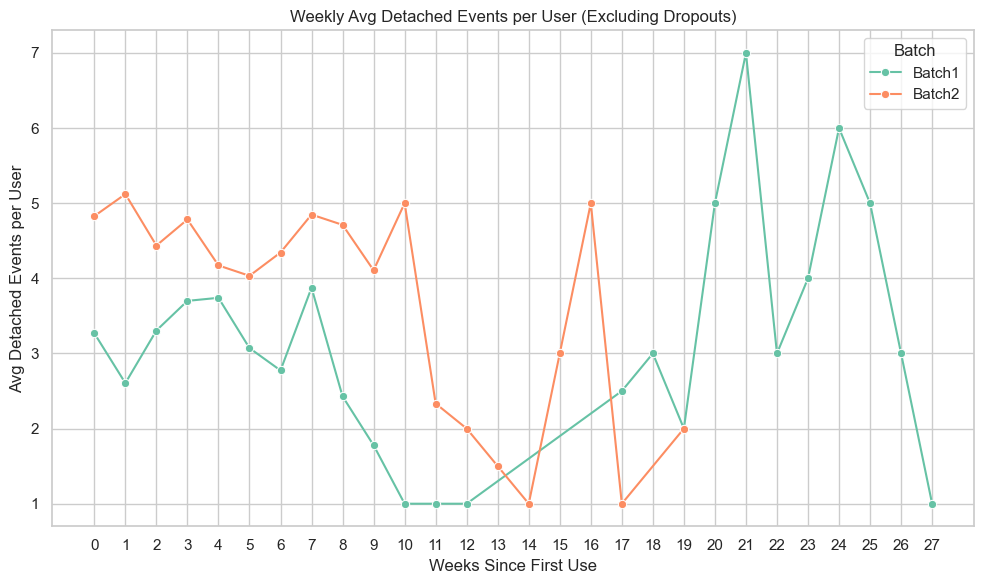

In [35]:
# ─── (4) Dropout 사용자 제외 ────────────────────────────────────────────────
drop_batch1 = [542,584,597,601,608,613,617,618,621,631,639,645]
drop_batch2 = [662,663,666,669,682,683,689,701,704,716,723,725,726,727,736,746,756,765,767,769]
dropouts    = set(drop_batch1 + drop_batch2)

df_det = df_det[~df_det['user_id'].isin(dropouts)]

# ─── (5) 주차별 사용자당 평균 Detached 이벤트 계산 ───────────────────────────
weekly_detached = (
    df_det
      .groupby(['batch','week_offset'])
      .agg(
          total_detached=('state','size'),
          unique_users   =('user_id','nunique')
      )
      .reset_index()
)
weekly_detached['avg_detached_per_user'] = (
    weekly_detached['total_detached'] / weekly_detached['unique_users']
)

# ─── (6) 시각화 ───────────────────────────────────────────────────────────
plt.figure(figsize=(10,6))
sns.lineplot(
    data=weekly_detached,
    x='week_offset', y='avg_detached_per_user',
    hue='batch', marker='o', palette='Set2'
)
plt.title('Weekly Avg Detached Events per User (Excluding Dropouts)')
plt.xlabel('Weeks Since First Use')
plt.ylabel('Avg Detached Events per User')
plt.xticks(sorted(weekly_detached['week_offset'].unique()))
plt.legend(title='Batch')
plt.tight_layout()
plt.savefig(output_dir/"WeeklyDetached_AvgExclDropouts.png")
plt.show()

# ─── (7) 결과 저장 ────────────────────────────────────────────────────────
weekly_detached.to_excel(
    output_dir/"WeeklyDetached_AvgExclDropouts.xlsx",
    index=False
)

### Source 3_Unlock State

#### 일별/주별 Unlock State 이벤트 집계 및 시각화

Loading Batch1: 66it [00:01, 43.66it/s]
Loading Batch2: 108it [00:02, 40.91it/s]


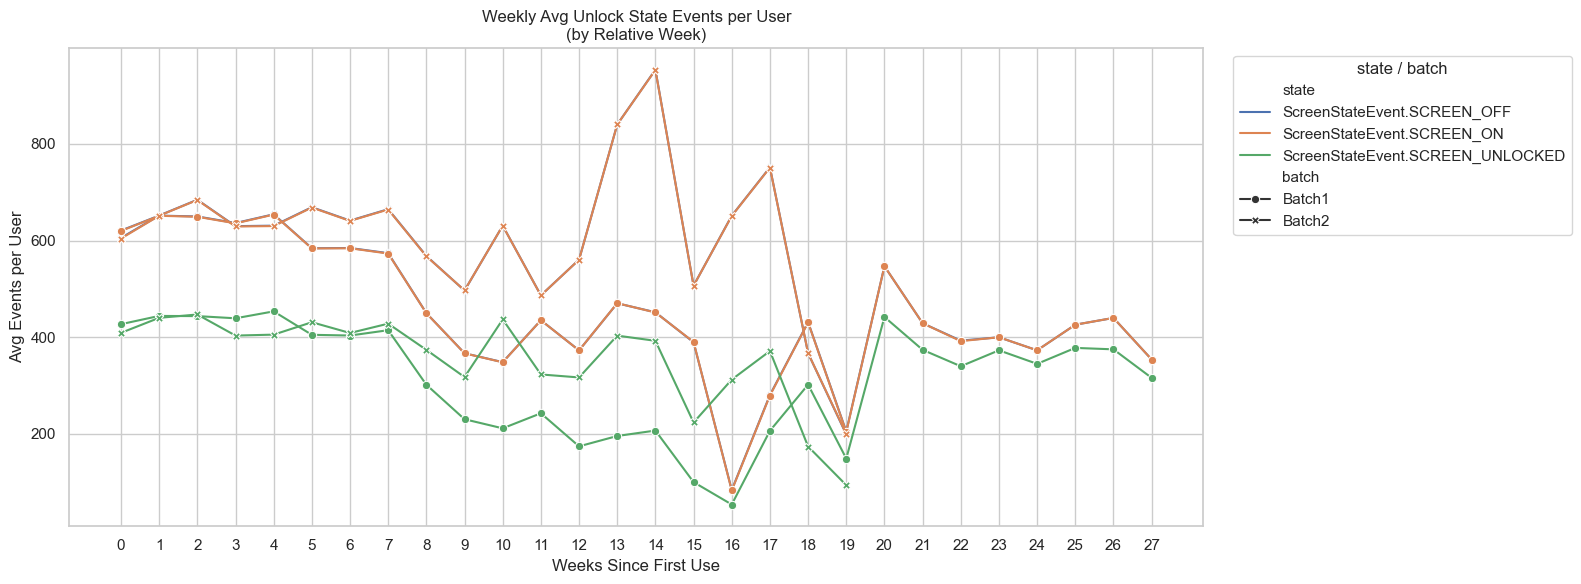

In [94]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm

# ─── 경로 설정 ───────────────────────────────────────────────────────────────
base_path = Path("/Users/yooseohyeon/Desktop/170325/eva_250121_processed")
output_dir = Path("./analysis_outputs/source3_unlock_state")
output_dir.mkdir(parents=True, exist_ok=True)

sns.set(style="whitegrid")

# ─── value 파싱 함수 ─────────────────────────────────────────────────────────
def parse_value(value_str):
    try:
        return json.loads(value_str.replace("'", '"'))
    except:
        return None

# ─── Source3 데이터 로딩 ─────────────────────────────────────────────────────
def load_source3_data():
    all_data = []
    for batch in ['Batch1', 'Batch2']:
        for user_folder in tqdm((base_path/batch).glob("cmp1_usr*"), desc=f"Loading {batch}"):
            uid = user_folder.name
            csv_file = user_folder/"source_3"/"data_source_3.csv"
            if csv_file.exists():
                df = pd.read_csv(csv_file)
                df['batch']   = batch
                df['user_id'] = uid
                all_data.append(df)
    return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()

unlock_df = load_source3_data()

# ─── 파싱 & Timestamp 변환 ────────────────────────────────────────────────────
unlock_df['parsed']    = unlock_df['value'].apply(parse_value)
unlock_df['state']     = unlock_df['parsed'].apply(lambda x: x.get('state') if x else None)
unlock_df['timestamp'] = pd.to_datetime(unlock_df['timestamp'], errors='coerce')
unlock_df.dropna(subset=['timestamp'], inplace=True)

# ─── 사용자별 첫 사용일(첫 timestamp) 계산 ───────────────────────────────────
first_days = (
    unlock_df
    .groupby(['batch','user_id'])['timestamp']
    .min()
    .reset_index()
    .rename(columns={'timestamp':'first_day'})
)
unlock_df = unlock_df.merge(first_days, on=['batch','user_id'], how='left')

# ─── 상대 주차 week_offset 계산 ──────────────────────────────────────────────
unlock_df['day_offset']  = (unlock_df['timestamp'] - unlock_df['first_day']).dt.days
unlock_df['week_offset'] = (unlock_df['day_offset'] // 7).astype(int)

# ─── (6) 주차별 Unlock 이벤트 집계 → 사용자당 평균 계산 추가 ───────────────────
#  6-1) 주차별·상태별 총 이벤트 수
weekly_counts = (
    unlock_df
      .groupby(['batch','week_offset','state'])
      .size()
      .reset_index(name='total_count')
)

#  6-2) 주차별 활성 사용자 수 (state 무관)
weekly_users = (
    unlock_df
      .groupby(['batch','week_offset'])['user_id']
      .nunique()
      .reset_index(name='unique_users')
)

#  6-3) 머지 & 평균 이벤트 수 계산
weekly_counts = weekly_counts.merge(
    weekly_users, on=['batch','week_offset'], how='left'
)
weekly_counts['avg_events_per_user'] = (
    weekly_counts['total_count'] / weekly_counts['unique_users']
)

# ─── (7) 시각화: avg_events_per_user 사용 ────────────────────────────────────
plt.figure(figsize=(16,6))
sns.lineplot(
    data=weekly_counts,
    x='week_offset', y='avg_events_per_user',
    hue='state', style='batch',
    markers=True, dashes=False
)
plt.title('Weekly Avg Unlock State Events per User\n(by Relative Week)')
plt.xlabel('Weeks Since First Use')
plt.ylabel('Avg Events per User')
plt.xticks(sorted(weekly_counts['week_offset'].unique()))
plt.legend(title='state / batch', bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.savefig(output_dir/'weekly_unlock_state_avg_per_user.png')
plt.show()

# ─── (8) 결과 저장 ─────────────────────────────────────────────────────────
weekly_counts.to_excel(
    output_dir/'weekly_unlock_state_avg_per_user.xlsx',
    index=False
)

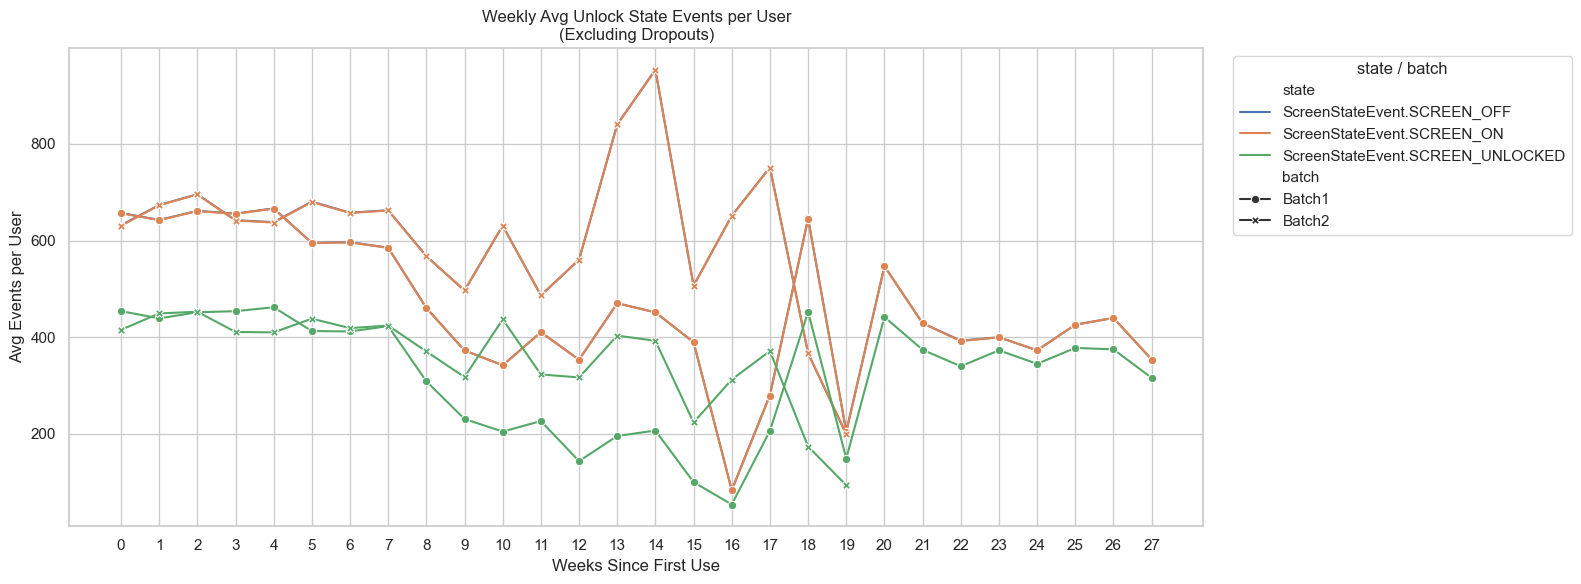

In [37]:
# ─── (5) Un­lock DataFrame에서 Dropout 사용자 필터링 ─────────────────────────
drop_batch1 = [542,584,597,601,608,613,617,618,621,631,639,645]
drop_batch2 = [662,663,666,669,682,683,689,701,704,716,723,725,726,727,736,746,756,765,767,769]
dropouts    = {f"cmp1_usr{u}" for u in drop_batch1 + drop_batch2}

# user_id 컬럼이 'cmp1_usrXXX' 형태라 가정
unlock_df = unlock_df[~unlock_df['user_id'].isin(dropouts)].copy()

# ─── (6) 주차별·상태별 총 이벤트 수 집계 ────────────────────────────────────
weekly_counts = (
    unlock_df
      .groupby(['batch','week_offset','state'])
      .size()
      .reset_index(name='total_count')
)

# ─── (7) 주차별 활성 사용자 수 집계 ─────────────────────────────────────────
weekly_users = (
    unlock_df
      .groupby(['batch','week_offset'])['user_id']
      .nunique()
      .reset_index(name='unique_users')
)

# ─── (8) 평균 이벤트 수 계산 및 병합 ────────────────────────────────────────
weekly_counts = weekly_counts.merge(
    weekly_users, on=['batch','week_offset'], how='left'
)
weekly_counts['avg_events_per_user'] = (
    weekly_counts['total_count'] / weekly_counts['unique_users']
)

# ─── (9) 시각화 ────────────────────────────────────────────────────────────
plt.figure(figsize=(16,6))
sns.lineplot(
    data=weekly_counts,
    x='week_offset', y='avg_events_per_user',
    hue='state', style='batch',
    markers=True, dashes=False
)
plt.title('Weekly Avg Unlock State Events per User\n(Excluding Dropouts)')
plt.xlabel('Weeks Since First Use')
plt.ylabel('Avg Events per User')
plt.xticks(sorted(weekly_counts['week_offset'].unique()))
plt.legend(title='state / batch', bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.savefig(output_dir/'weekly_unlock_state_avg_excl_dropouts.png')
plt.show()

# ─── (10) 결과 저장 ─────────────────────────────────────────────────────────
weekly_counts.to_excel(
    output_dir/'weekly_unlock_state_avg_excl_dropouts.xlsx',
    index=False
)

['ScreenStateEvent.SCREEN_ON' 'ScreenStateEvent.SCREEN_UNLOCKED'
 'ScreenStateEvent.SCREEN_OFF']


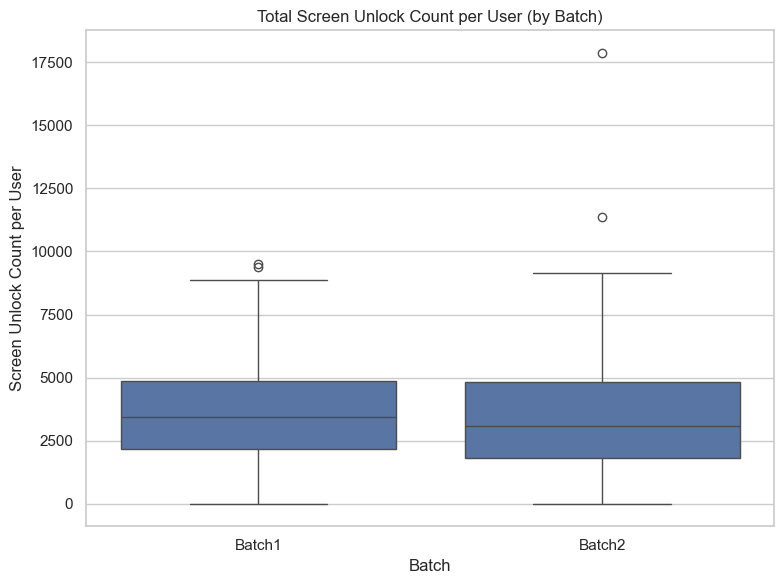

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ─── 필터: SCREEN_ON 이벤트만 사용 ─────────────────────────────
screen_unlock_df = unlock_df[unlock_df["state"] == "ScreenStateEvent.SCREEN_UNLOCKED"]

# ─── 사용자별 Unlock 총합 계산 ───────────────────────────────
user_unlock_counts = (
    screen_unlock_df
    .groupby(["batch", "user_id"])
    .size()
    .reset_index(name="unlock_count")
)
print(unlock_df['state'].dropna().unique())# ─── Boxplot 시각화 ─────────────────────────────────────────
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=user_unlock_counts,
    x="batch",
    y="unlock_count"
)
plt.title("Total Screen Unlock Count per User (by Batch)")
plt.xlabel("Batch")
plt.ylabel("Screen Unlock Count per User")
plt.tight_layout()
plt.show()

### Source_18 User Interactions (source_18)

#### 전체 EVAPP 기능별 사용량 분석

100%|██████████| 108/108 [00:00<00:00, 503.99it/s]


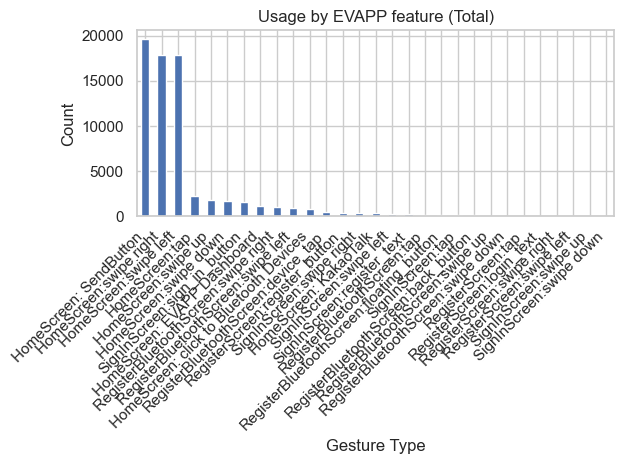

In [123]:
# Step 2: Source18 원본 데이터 로딩
def parse_value(value_str):
    try:
        value_dict = json.loads(value_str.replace("'", '"'))
        return value_dict
    except Exception:
        return None

def load_source18_data():
    all_data = []
    for batch in ['Batch1', 'Batch2']:
        batch_path = base_path / batch
        for user_folder in tqdm(list(batch_path.glob('cmp1_usr*'))):
            user_id = user_folder.name.replace('cmp1_usr', '')
            source_folder = user_folder / 'source_18'
            csv_file = source_folder / 'data_source_18.csv'
            if csv_file.exists():
                try:
                    df = pd.read_csv(csv_file)
                    if not df.empty and 'value' in df.columns:
                        df['user_id'] = int(user_id)
                        df['batch'] = batch
                        all_data.append(df)
                    else:
                        # ✅ 파일이 비어있거나 컬럼 없음 → 더미 row 추가
                        all_data.append(pd.DataFrame([{
                            'user_id': int(user_id),
                            'batch': batch,
                            'value': None  # gestureType, timestamp 등은 이후 분석 시 NaN 처리됨
                        }]))
                except Exception as e:
                    print(f"❌ Error reading {csv_file}: {e}")
                    all_data.append(pd.DataFrame([{
                        'user_id': int(user_id),
                        'batch': batch,
                        'value': None
                    }]))
            else:
                # ✅ 파일이 아예 없을 때도 더미 row 추가
                all_data.append(pd.DataFrame([{
                    'user_id': int(user_id),
                    'batch': batch,
                    'value': None
                }]))

    return pd.concat(all_data, ignore_index=True)


# Source18 데이터 통합
interaction_df = load_source18_data()
#daily, weekly, total, activity_level = analyze_user_interaction(df_user_interaction)
# gestureType 파싱
interaction_df['parsed'] = interaction_df['value'].apply(parse_value)
interaction_df['gestureType'] = interaction_df['parsed'].apply(lambda x: x.get('gestureType') if x else None)

# Step 3: 전체 EVAPP 기능별 사용량 분석
gesture_counts = interaction_df['gestureType'].value_counts()

# ✅ 전체 기능 사용량 엑셀 저장
gesture_counts.to_excel(output_dir / "2.3_UserInteraction_전체기능사용량.xlsx")

# 전체 기능별 사용량 시각화 (전체 total 기준, 참고용)
gesture_counts.plot(kind='bar')
plt.title('Usage by EVAPP feature (Total)')
plt.ylabel('Count')
plt.xlabel('Gesture Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(output_dir / "2.3_UserInteraction_전체기능사용량_세로막대_Total.png")
plt.show()


#### Batch1 vs Batch2 기능별 "사용자당 평균" 사용량 비교

In [127]:
# Step 1~3 완료 후 이어서 사용
# interaction_df는 앞에서 정의되어 있어야 함

# 🔹 gestureType 없는 row 제외한 유효 사용자 목록
activity_df = interaction_df[interaction_df['gestureType'].notna()].drop_duplicates(subset=['user_id', 'batch'])

# Step 4: Batch1 vs Batch2 기능별 사용자당 평균 사용량 비교

# (1) 사용자 수 계산
batch_user_counts = activity_df['batch'].value_counts()

# (2) Batch별 gestureType count
batch_gesture_counts = interaction_df.groupby(['batch', 'gestureType']).size().unstack(fill_value=0)

# (3) Batch별 사용자당 평균 gestureType 사용량
batch_gesture_means = batch_gesture_counts.div(batch_user_counts, axis=0)

# ▶︎ 시각적으로 보기 좋게 스타일링된 테이블 출력
styled_table = batch_gesture_means.style \
    .format("{:.1f}") \
    .background_gradient(axis=0, cmap="YlGnBu") \
    .set_caption("📊 Batch별 기능별 사용자당 평균 사용량")

display(styled_table)
# ✅ 결과 저장
batch_gesture_means.to_excel("2.3_UserInteraction_Batch별기능사용량_사용자당평균.xlsx")

gestureType,HomeScreen: EVAPP Dashboard,HomeScreen: KakaoTalk,HomeScreen: SendButton,HomeScreen: click to Bluetooth Devices,HomeScreen:swipe down,HomeScreen:swipe left,HomeScreen:swipe right,HomeScreen:swipe up,HomeScreen:tap,RegisterBluetoothScreen:back_button,RegisterBluetoothScreen:device_tap,RegisterBluetoothScreen:floating_button,RegisterBluetoothScreen:swipe down,RegisterBluetoothScreen:swipe left,RegisterBluetoothScreen:swipe right,RegisterBluetoothScreen:swipe up,RegisterBluetoothScreen:tap,RegisterScreen:login_text,RegisterScreen:register_button,RegisterScreen:swipe left,RegisterScreen:swipe right,RegisterScreen:tap,SignInScreen:register_text,SignInScreen:sign_in_button,SignInScreen:swipe down,SignInScreen:swipe left,SignInScreen:swipe right,SignInScreen:swipe up,SignInScreen:tap
batch,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Batch1,6.6,1.6,115.9,4.3,8.2,117.4,115.6,9.2,14.1,0.5,2.2,0.8,0.1,3.8,1.9,0.1,1.2,0.5,1.7,0.0,0.0,0.2,1.0,17.5,0.0,0.8,1.1,0.0,0.9
Batch2,7.2,2.2,122.8,5.7,11.1,105.0,106.5,12.0,14.0,0.8,3.0,0.9,0.6,6.8,9.0,0.7,1.1,0.2,3.0,0.2,0.2,0.4,1.4,5.2,0.0,1.7,3.2,0.2,0.8


/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_41051/3995031258.py:32: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_41051/3995031258.py:32: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_41051/3995031258.py:32: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_41051/3995031258.py:32: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_41051/3995031258.py:32: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_41051/3995031258.py:32: U

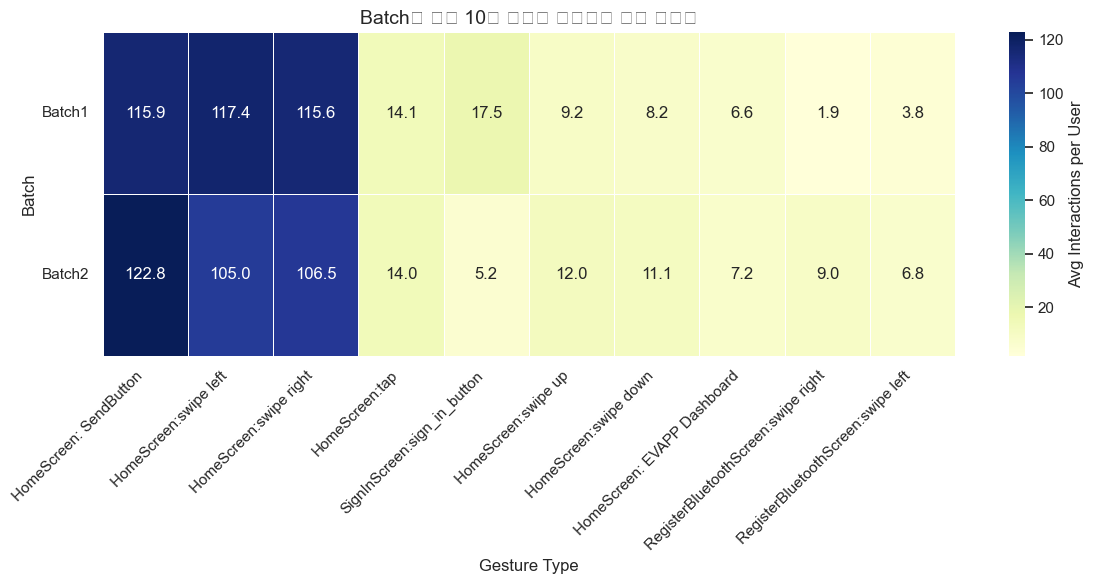

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 Step 1: 두 배치 평균을 더한 기준으로 Top 10 gestureType 추출
top10_gestures = (
    batch_gesture_means
    .mean(axis=0)
    .sort_values(ascending=False)
    .head(10)
    .index
)

# 🔹 Step 2: Top 10만 필터링
top10_means = batch_gesture_means[top10_gestures]

# 🔹 Step 3: Heatmap 시각화
plt.figure(figsize=(12, 6))
sns.heatmap(
    top10_means,
    annot=True,
    fmt=".1f",
    cmap="YlGnBu",
    linewidths=0.5,
    cbar_kws={"label": "Avg Interactions per User"},
)

plt.title("Batch별 상위 10개 기능의 사용자당 평균 사용량", fontsize=14)
plt.xlabel("Gesture Type")
plt.ylabel("Batch")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(output_dir / "2.3_Top10GestureUsage_Heatmap.png")
plt.show()

#### Top 10 기능만 추려서 시각화 (사용자당 평균 기준)

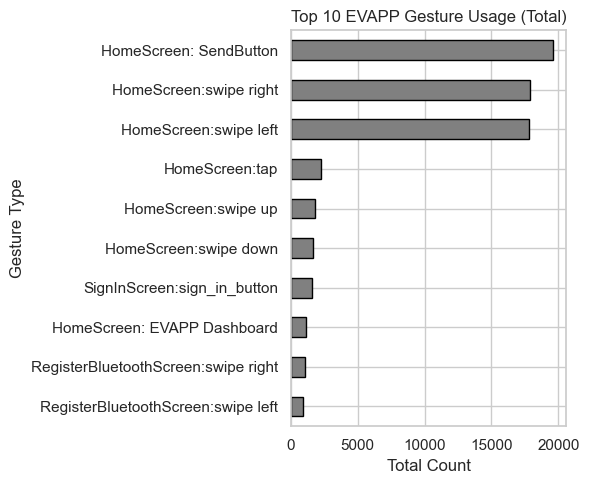

<Figure size 600x500 with 0 Axes>

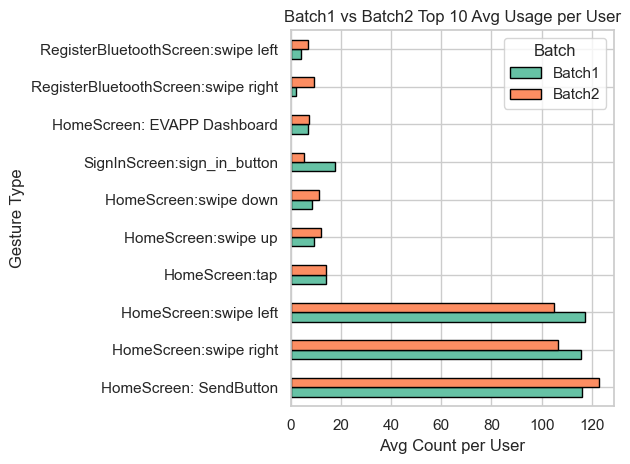

<Figure size 600x400 with 0 Axes>

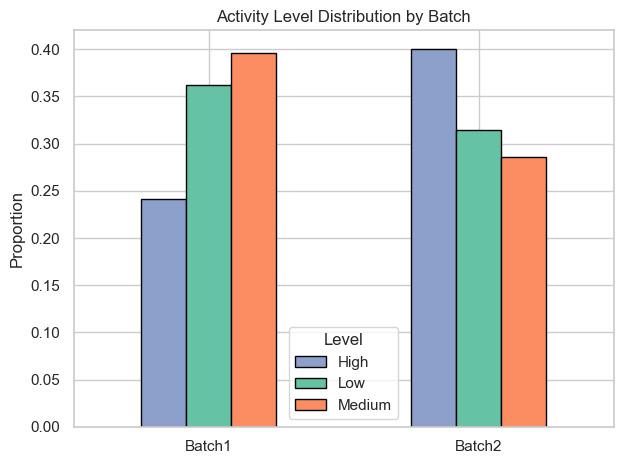

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ─── 1) 전체 기능 사용량이 이미 계산된 interaction_df ─────────────────────────
# gesture_counts = interaction_df['gestureType'].value_counts()

# ─── 2) Batch별 사용자 수 계산 ──────────────────────────────────────────────
# 고유의 (gestureType이 있는) 사용자만 셉니다
active_users = interaction_df[interaction_df['gestureType'].notna()] \
                 .drop_duplicates(subset=['batch','user_id'])
batch_user_counts = active_users['batch'].value_counts()

# ─── 3) Batch별 기능별 총 사용량 집계 ────────────────────────────────────────
batch_gesture_counts = (
    interaction_df[interaction_df['gestureType'].notna()]
      .groupby(['batch','gestureType'])
      .size()
      .unstack(fill_value=0)
)

# ─── 4) 사용자당 평균 사용량 계산 ───────────────────────────────────────────
batch_gesture_means = batch_gesture_counts.div(batch_user_counts, axis=0)

# ✅ 엑셀로 저장
batch_gesture_means.to_excel(output_dir / "2.3_UserInteraction_Batch별기능평균.xlsx")

# ─── 5) 시각화: Top 10 기능 (전체 사용자 기준) ─────────────────────────────
top10 = gesture_counts.nlargest(10).index.tolist()

# (a) 전체 Top10 총 사용량 가로막대
plt.figure(figsize=(6,5))
gesture_counts[top10].sort_values().plot(
    kind='barh', color='gray', edgecolor='black'
)
plt.title('Top 10 EVAPP Gesture Usage (Total)')
plt.xlabel('Total Count')
plt.ylabel('Gesture Type')
plt.tight_layout()
plt.savefig(output_dir / "2.3_UserInteraction_Top10_Total.png")
plt.show()

# (b) Batch별 Top10 사용자당 평균 비교
plt.figure(figsize=(6,5))
batch_gesture_means.loc[:, top10].T.plot(
    kind='barh', 
    color=['#66C2A5','#FC8D62'], 
    edgecolor='black'
)
plt.title('Batch1 vs Batch2 Top 10 Avg Usage per User')
plt.xlabel('Avg Count per User')
plt.ylabel('Gesture Type')
plt.legend(title='Batch')
plt.tight_layout()
plt.savefig(output_dir / "2.3_UserInteraction_Top10_BatchCompare.png")
plt.show()

# ─── 6) 활동 수준 분포 (Interaction량 기준) ─────────────────────────────────
# 사용자별 총 인터랙션 건수 계산
user_counts = (
    interaction_df[interaction_df['gestureType'].notna()]
      .groupby(['user_id','batch'])['gestureType']
      .count()
      .reset_index(name='count')
)

# quantile로 Low/Med/High 분류
q33, q66 = user_counts['count'].quantile([.33, .66])
def lvl(c):
    return 'Low'    if c < q33 \
         else 'Medium' if c < q66 \
         else 'High'
user_counts['activity_level'] = user_counts['count'].apply(lvl)

# 배치별 비율
lvl_dist = (
    user_counts
      .groupby(['batch','activity_level'])
      .size()
      .unstack(fill_value=0)
      .pipe(lambda df: df.div(df.sum(axis=1), axis=0))
)

# 시각화
plt.figure(figsize=(6,4))
lvl_dist.plot(
    kind='bar', stacked=False,
    color=['#8DA0CB','#66C2A5','#FC8D62'],
    edgecolor='black'
)
plt.title('Activity Level Distribution by Batch')
plt.ylabel('Proportion')
plt.xlabel('')
plt.legend(title='Level')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(output_dir / "2.3_UserInteraction_ActivityLevel.png")
plt.show()

In [43]:
sns.set(style="whitegrid")

# ─── 가정: interaction_df 에 ['batch','user_id','timestamp','gestureType'] 컬럼이 있음

# 1) timestamp → datetime
interaction_df['timestamp'] = pd.to_datetime(
    interaction_df['timestamp'], errors='coerce'
)

# 2) 사용자별 첫 사용일(first_day) 계산
first_day_df = (
    interaction_df
      .groupby(['batch','user_id'])['timestamp']
      .min()
      .reset_index()
      .rename(columns={'timestamp': 'first_day'})
)

# 3) 병합
interaction_df = interaction_df.merge(
    first_day_df,
    on=['batch','user_id'],
    how='left'
)

# 4) 상대 오프셋 계산
#    day_offset 에 NaN이 있을 수 있으니 fillna(0) 후 정수 변환
interaction_df['day_offset'] = (
    interaction_df['timestamp'] - interaction_df['first_day']
).dt.days
interaction_df['week_offset'] = (
    (interaction_df['day_offset'] // 7)
      .fillna(0)
      .astype(int)
)

# 이제 week_offset 컬럼이 잘 만들어졌는지 확인
print(interaction_df[['batch','user_id','timestamp','first_day','week_offset']].head())

# (이후 첫 8주 필터링 등 앞서 드린 로직을 이어서 사용하시면 됩니다)

    batch  user_id           timestamp           first_day  week_offset
0  Batch1      625 2024-11-10 11:57:58 2024-11-10 11:57:58            0
1  Batch1      625 2024-11-10 11:57:59 2024-11-10 11:57:58            0
2  Batch1      625 2024-11-10 11:58:18 2024-11-10 11:57:58            0
3  Batch1      625 2024-11-10 11:58:19 2024-11-10 11:57:58            0
4  Batch1      625 2024-11-10 11:58:34 2024-11-10 11:57:58            0


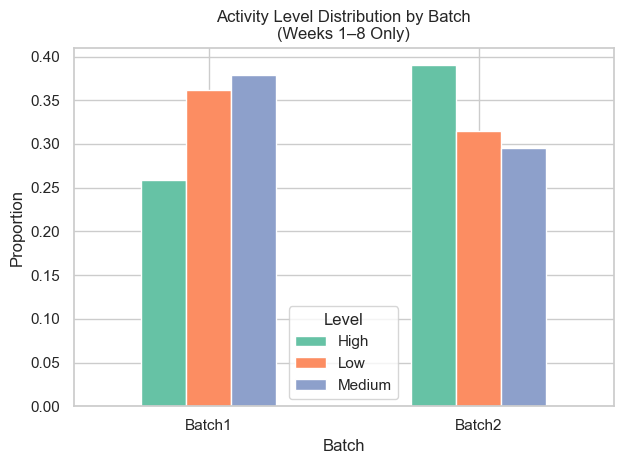

In [44]:
# ─── 0. week_offset 이 이미 계산되어 있다고 가정 ──────────────────────────────
# interaction_df 에는 batch, user_id, timestamp, week_offset, gestureType 가 있다고 가정합니다.

# ─── 1. 첫 8주(0~7) 데이터만 필터링 ────────────────────────────────────────
df8 = interaction_df[interaction_df['week_offset'] <= 7].copy()

# ─── 2. gestureType 있는 이벤트만 남기기 & 사용자-배치별 고유화 ───────────────
#    (activity_df 는 plot용 레이블만 필요하므로 drop_duplicates)
activity_df8 = df8[df8['gestureType'].notna()] \
                .drop_duplicates(subset=['user_id', 'batch'])

# ─── 3. 사용자별 gesture count (첫 8주 기준) ───────────────────────────────
user_gesture_counts8 = df8[df8['gestureType'].notna()] \
    .groupby(['user_id', 'batch'])['gestureType'] \
    .count() \
    .reset_index(name='count')

# ─── 4. Low/Medium/High 분류 (33%,66% 기준) ────────────────────────────────
quantiles8 = user_gesture_counts8['count'].quantile([0.33, 0.66]).values

def classify_level_8(c):
    if c < quantiles8[0]:
        return 'Low'
    elif c < quantiles8[1]:
        return 'Medium'
    else:
        return 'High'

user_gesture_counts8['activity_level'] = \
    user_gesture_counts8['count'].apply(classify_level_8)

# ─── 5. 배치별 비율 계산 ───────────────────────────────────────────────────
batch_level_counts8 = user_gesture_counts8.groupby(
    ['batch', 'activity_level']
).size().unstack(fill_value=0)
batch_level_props8 = batch_level_counts8.div(
    batch_level_counts8.sum(axis=1), axis=0
)

# ─── 6. 시각화 ─────────────────────────────────────────────────────────────
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
ax = batch_level_props8.plot(
    kind='bar',
    stacked=False,
    color=['#66C2A5','#FC8D62','#8DA0CB']  # 예시 색상: High/Low/Medium
)
ax.set_title('Activity Level Distribution by Batch\n(Weeks 1–8 Only)')
ax.set_ylabel('Proportion')
ax.set_xlabel('Batch')
ax.legend(title='Level')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [18]:
# Step 1~3 완료 후 이어서 사용
# interaction_df는 앞에서 정의되어 있어야 함

# 🔹 gestureType 없는 row 제외한 유효 사용자 목록
activity_df = interaction_df[interaction_df['gestureType'].notna()].drop_duplicates(subset=['user_id', 'batch'])

# Step 4: Batch1 vs Batch2 기능별 사용자당 평균 사용량 비교

# (1) 사용자 수 계산
batch_user_counts = activity_df['batch'].value_counts()

# (2) Batch별 gestureType count
batch_gesture_counts = interaction_df.groupby(['batch', 'gestureType']).size().unstack(fill_value=0)

# (3) Batch별 사용자당 평균 gestureType 사용량
batch_gesture_means = batch_gesture_counts.div(batch_user_counts, axis=0)

# ▶︎ 시각적으로 보기 좋게 스타일링된 테이블 출력
styled_table = batch_gesture_means.style \
    .format("{:.1f}") \
    .background_gradient(axis=0, cmap="YlGnBu") \
    .set_caption("📊 Batch별 기능별 사용자당 평균 사용량")

display(styled_table)
# ✅ 결과 저장
#batch_gesture_means.to_excel(output_dir / "2.3_UserInteraction_Batch별기능사용량_사용자당평균.xlsx")

gestureType,HomeScreen: EVAPP Dashboard,HomeScreen: KakaoTalk,HomeScreen: SendButton,HomeScreen: click to Bluetooth Devices,HomeScreen:swipe down,HomeScreen:swipe left,HomeScreen:swipe right,HomeScreen:swipe up,HomeScreen:tap,RegisterBluetoothScreen:back_button,RegisterBluetoothScreen:device_tap,RegisterBluetoothScreen:floating_button,RegisterBluetoothScreen:swipe down,RegisterBluetoothScreen:swipe left,RegisterBluetoothScreen:swipe right,RegisterBluetoothScreen:swipe up,RegisterBluetoothScreen:tap,RegisterScreen:login_text,RegisterScreen:register_button,RegisterScreen:swipe left,RegisterScreen:swipe right,RegisterScreen:tap,SignInScreen:register_text,SignInScreen:sign_in_button,SignInScreen:swipe down,SignInScreen:swipe left,SignInScreen:swipe right,SignInScreen:swipe up,SignInScreen:tap
batch,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Batch1,6.6,1.6,115.9,4.3,8.2,117.4,115.6,9.2,14.1,0.5,2.2,0.8,0.1,3.8,1.9,0.1,1.2,0.5,1.7,0.0,0.0,0.2,1.0,17.5,0.0,0.8,1.1,0.0,0.9
Batch2,7.1,2.2,121.6,5.6,11.0,104.0,105.5,11.9,13.8,0.8,2.9,0.9,0.6,6.8,8.9,0.7,1.1,0.2,3.0,0.2,0.2,0.4,1.4,5.2,0.0,1.7,3.2,0.2,0.8


#### 일별/주별 interactions 집계 및 Batch1/Batch2 비교 시각화

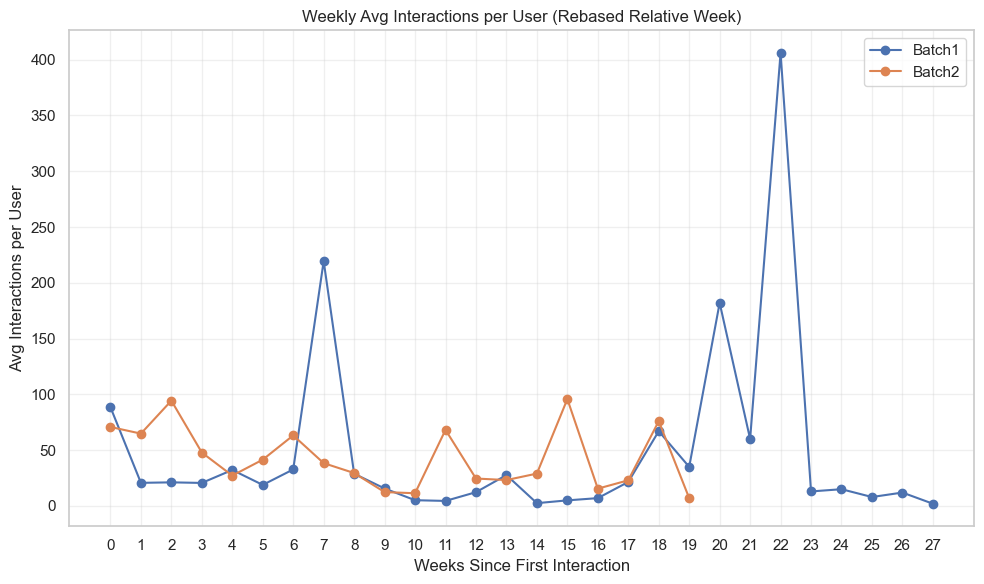

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ─── 설정 ────────────────────────────────────────────────────────────────
output_dir = Path("./analysis_outputs")
output_dir.mkdir(exist_ok=True, parents=True)

# interaction_df 는 이미 load & preprocessing 되어 있어야 합니다.
# 최소한 ['batch','user_id','timestamp','gestureType'] 컬럼이 있어야 합니다.

# 1) timestamp → datetime
interaction_df['timestamp'] = pd.to_datetime(interaction_df['timestamp'], errors='coerce')

# 2) 사용자별 첫 사용일(first_day) 계산
first_days = (
    interaction_df
      .groupby(['batch','user_id'])['timestamp']
      .min()
      .reset_index(name='first_day')
)

# 3) 원본에 병합 & 상대 주차 계산
# 1) first_day 병합 & day_offset 계산
df = interaction_df.merge(first_days, on=['batch','user_id'], how='left')
df['day_offset'] = (df['timestamp'] - df['first_day']).dt.days

# 2) day_offset이 NaN인 행(=first_day 또는 timestamp가 없는 경우) 제거
df = df.dropna(subset=['day_offset']).copy()

# 3) week_offset 계산
df['week_offset'] = (df['day_offset'] // 7).astype(int)

# 4) 사용자별 “첫 인터랙션 주차” 계산
first_event = (
    df.groupby(['batch','user_id'])['week_offset']
      .min()
      .reset_index(name='first_event_week')
)

# 5) 병합 & rebase (첫 인터랙션 주차를 0으로)
df = df.merge(first_event, on=['batch','user_id'], how='left')
df['rebase_week'] = df['week_offset'] - df['first_event_week']

# 6) 첫 인터랙션 이전(음수 rebase_week) 데이터 삭제
df = df[df['rebase_week'] >= 0].copy()

# 7) 주차별 총 이벤트 수, 고유 사용자 수 집계 (rebase_week 기준)
weekly = (
    df
      .groupby(['batch','rebase_week'])
      .agg(
         total_interactions=('user_id','count'),
         unique_users       =('user_id','nunique')
      )
      .reset_index()
)

# 8) 사용자당 평균 인터랙션 계산
weekly['avg_interactions_per_user'] = (
    weekly['total_interactions'] / weekly['unique_users']
)

# 9) 시각화
plt.figure(figsize=(10,6))
for batch in ['Batch1','Batch2']:
    sub = weekly[weekly['batch']==batch]
    plt.plot(
        sub['rebase_week'],
        sub['avg_interactions_per_user'],
        marker='o', label=batch
    )

plt.title('Weekly Avg Interactions per User (Rebased Relative Week)')
plt.xlabel ('Weeks Since First Interaction')
plt.ylabel ('Avg Interactions per User')
plt.xticks(sorted(weekly['rebase_week'].unique()))
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(output_dir/"2.3_UserInteraction_weekly_avg_rebased.png")
plt.show()

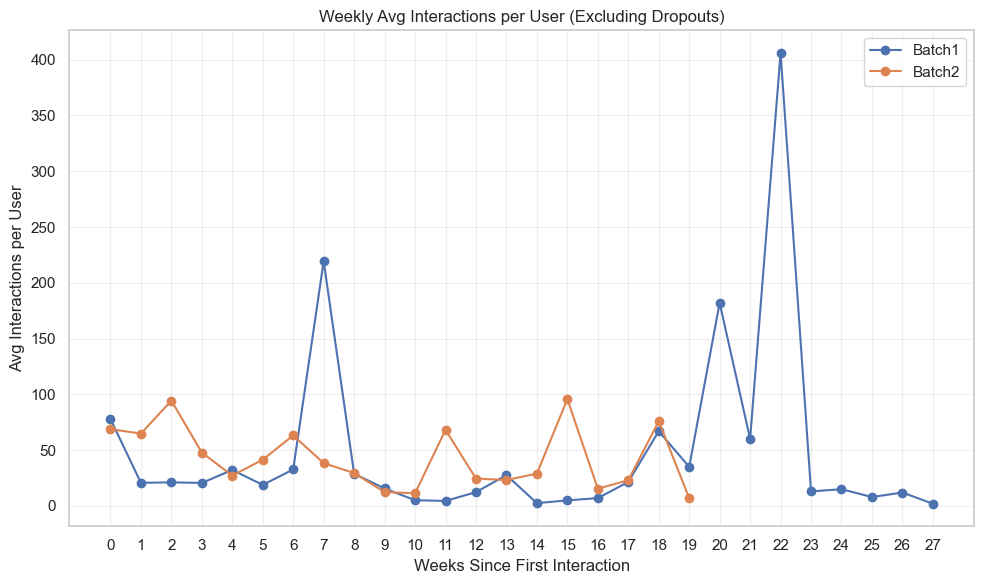

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ─── 설정 ────────────────────────────────────────────────────────────────
output_dir = Path("./analysis_outputs")
output_dir.mkdir(exist_ok=True, parents=True)

# 제외할 Dropout 사용자 리스트 (숫자형 → cmp1_usr 형식)
drop_batch1 = [542,584,597,601,608,613,617,618,621,631,639,645]
drop_batch2 = [662,663,666,669,682,683,689,701,704,716,723,725,726,727,736,746,756,765,767,769]
dropouts = {f"cmp1_usr{u}" for u in drop_batch1 + drop_batch2}

# interaction_df 는 이미 로드되어 있어야 합니다.
# 최소 ['batch','user_id','timestamp','gestureType'] 칼럼이 존재해야 함.

# 1) Dropout 사용자 제외
df = interaction_df[~interaction_df['user_id'].isin(dropouts)].copy()

# 2) timestamp → datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# 3) 사용자별 첫 사용일(first_day) 계산
first_days = (
    df.groupby(['batch','user_id'])['timestamp']
      .min()
      .reset_index(name='first_day')
)

# 4) 병합 & day_offset, week_offset 계산
df = df.merge(first_days, on=['batch','user_id'], how='left')
df['day_offset']  = (df['timestamp'] - df['first_day']).dt.days.fillna(0)
df['week_offset'] = (df['day_offset'] // 7).astype(int)

# 5) 사용자별 첫 인터랙션 주차 계산
first_event = (
    df.groupby(['batch','user_id'])['week_offset']
      .min()
      .reset_index(name='first_event_week')
)

# 6) rebase: 첫 인터랙션 전 주(음수) 제외, 주차 재조정
df = df.merge(first_event, on=['batch','user_id'], how='left')
df['rebase_week'] = df['week_offset'] - df['first_event_week']
df = df[df['rebase_week'] >= 0].copy()

# 7) 주차별 집계
weekly = (
    df.groupby(['batch','rebase_week'])
      .agg(
         total_interactions=('user_id','count'),
         unique_users       =('user_id','nunique')
      )
      .reset_index()
)
weekly['avg_interactions_per_user'] = (
    weekly['total_interactions'] / weekly['unique_users']
)

# 8) 시각화
plt.figure(figsize=(10,6))
for batch in ['Batch1','Batch2']:
    sub = weekly[weekly['batch']==batch]
    plt.plot(
        sub['rebase_week'],
        sub['avg_interactions_per_user'],
        marker='o', label=batch
    )
plt.title('Weekly Avg Interactions per User (Excluding Dropouts)')
plt.xlabel ('Weeks Since First Interaction')
plt.ylabel ('Avg Interactions per User')
plt.xticks(sorted(weekly['rebase_week'].unique()))
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(output_dir/"weekly_avg_excl_dropouts.png")
plt.show()

# 9) 결과 저장
weekly.to_excel(output_dir/"weekly_avg_excl_dropouts.xlsx", index=False)

#### Retention

100%|██████████| 108/108 [00:00<00:00, 472.53it/s]


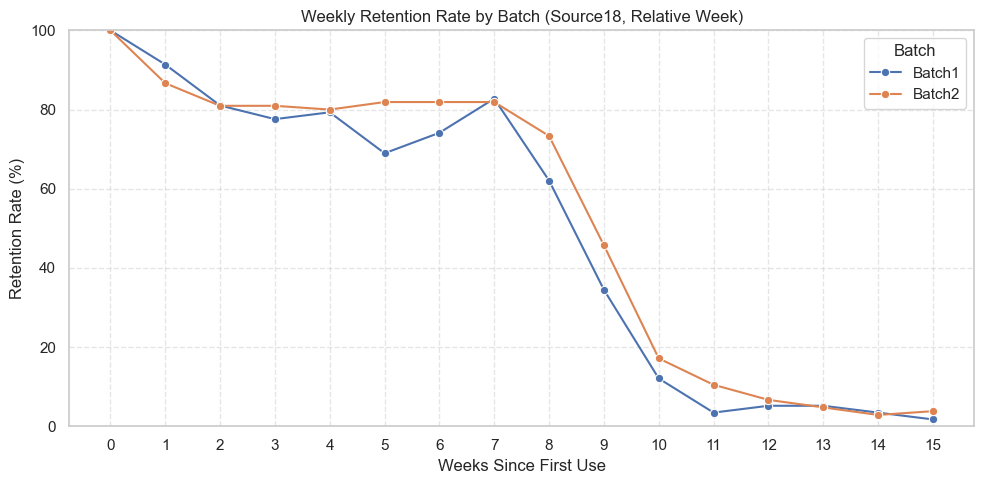

In [139]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from tqdm import tqdm

# 🔹 경로 설정
base_path = Path("/Users/yooseohyeon/Desktop/170325/eva_250121_processed")
output_dir = Path("./analysis_outputs")
output_dir.mkdir(exist_ok=True, parents=True)

sns.set(style="whitegrid")

# 🔹 JSON 파싱 함수
def parse_value(value_str):
    try:
        return json.loads(value_str.replace("'", '"'))
    except Exception:
        return None

# 🔹 Source18 데이터 불러오기
def load_source18_data(base_path):
    all_data = []
    for batch in ['Batch1', 'Batch2']:
        batch_path = base_path / batch
        for user_folder in tqdm(list(batch_path.glob('cmp1_usr*'))):
            user_id = user_folder.name.replace('cmp1_usr', '')
            source_folder = user_folder / 'source_18'
            csv_file = source_folder / 'data_source_18.csv'

            if csv_file.exists():
                try:
                    df = pd.read_csv(csv_file)
                    if not df.empty and 'value' in df.columns:
                        df['user_id'] = f"cmp1_usr{user_id}"
                        df['batch'] = batch
                        all_data.append(df)
                    else:
                        all_data.append(pd.DataFrame([{
                            'user_id': f"cmp1_usr{user_id}",
                            'batch': batch,
                            'value': None
                        }]))
                except Exception as e:
                    print(f"❌ Error reading {csv_file}: {e}")
                    all_data.append(pd.DataFrame([{
                        'user_id': f"cmp1_usr{user_id}",
                        'batch': batch,
                        'value': None
                    }]))
            else:
                all_data.append(pd.DataFrame([{
                    'user_id': f"cmp1_usr{user_id}",
                    'batch': batch,
                    'value': None
                }]))
    return pd.concat(all_data, ignore_index=True)

# 🔹 데이터 로드 및 전처리
interaction_df = load_source18_data(base_path)
interaction_df['timestamp'] = pd.to_datetime(interaction_df['timestamp'], errors='coerce')
interaction_df = interaction_df[interaction_df['timestamp'].notna()]

# 🔹 사용자별 첫 활동일 기준 상대 주차 계산
first_dates = interaction_df.groupby('user_id')['timestamp'].min().reset_index()
first_dates.rename(columns={'timestamp': 'first_day'}, inplace=True)
interaction_df = interaction_df.merge(first_dates, on='user_id', how='left')
interaction_df['day_offset'] = (interaction_df['timestamp'] - interaction_df['first_day']).dt.days
interaction_df['week_offset'] = (interaction_df['day_offset'] // 7).astype(int)

# 🔹 주별 리텐션 계산
retention_weekly = (
    interaction_df[['batch', 'user_id', 'week_offset']]
    .drop_duplicates()
    .groupby(['batch', 'week_offset'])['user_id']
    .nunique()
    .reset_index(name='retained_users')
)

# 🔹 Cohort 크기: 배치별 전체 사용자 수
cohort_sizes = interaction_df.groupby('batch')['user_id'].nunique().to_dict()
retention_weekly['cohort_size'] = retention_weekly['batch'].map(cohort_sizes)
retention_weekly['retention_rate (%)'] = (
    retention_weekly['retained_users'] / retention_weekly['cohort_size'] * 100
)

# 🔹 필터링 (예: 0~20주까지만)
MAX_WEEK = 15
retention_weekly = retention_weekly[retention_weekly['week_offset'] <= MAX_WEEK]

# 🔹 시각화: 꺾은선 그래프
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=retention_weekly,
    x='week_offset',
    y='retention_rate (%)',
    hue='batch',
    marker='o'
)
plt.title('Weekly Retention Rate by Batch (Source18, Relative Week)')
plt.xlabel('Weeks Since First Use')
plt.ylabel('Retention Rate (%)')
plt.xticks(range(0, MAX_WEEK + 1))
plt.ylim(0, 100)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Batch')
plt.tight_layout()
plt.savefig(output_dir / 'weekly_retention_by_batch_line_relative.png')
plt.show()

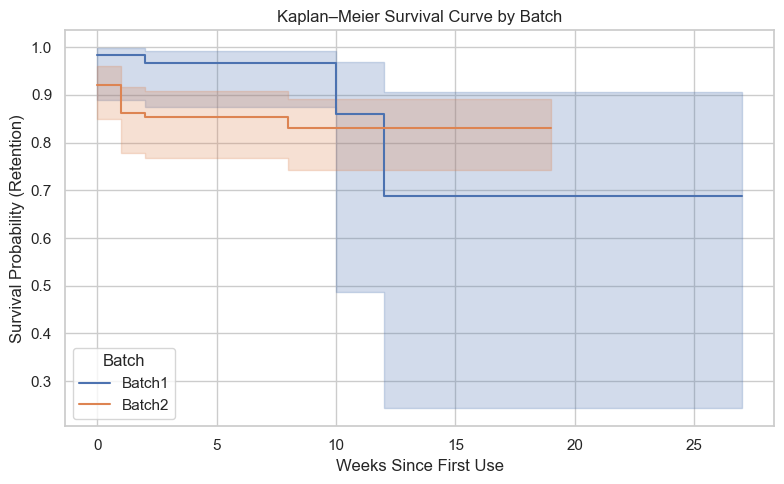

Log-Rank Test: χ² = 3.180, p = 0.075


In [141]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# ── A) user_week_map 생성 ────────────────────────────────────────────────
# interaction_df 에서 user_id별 week_offset 목록 추출
user_week_map = (
    interaction_df
      .groupby('user_id')['week_offset']
      .unique()
      .to_dict()
)

# ── B) dropout_ids 정의 ─────────────────────────────────────────────────
batch1_nums = [542,584,597,601,608,613,617,618,621,631,639,645]
batch2_nums = [662,663,666,669,682,683,689,701,704,716,723,725,726,727,736,746,756,765,767,769]
dropout_ids = {f"cmp1_usr{uid}" for uid in batch1_nums + batch2_nums}

# ── C) 생존분석용 데이터프레임 생성 ──────────────────────────────────────
records = []
for uid, weeks in user_week_map.items():
    duration = int(weeks.max()) if len(weeks)>0 else 0
    event = 1 if uid in dropout_ids else 0
    batch = "Batch1" if int(uid.replace("cmp1_usr","")) < 660 else "Batch2"
    records.append({
        "duration": duration,
        "event": event,
        "batch": batch
    })
df_surv = pd.DataFrame(records)

# ── D) Kaplan–Meier 생존곡선 ─────────────────────────────────────────────
kmf = KaplanMeierFitter()
plt.figure(figsize=(8,5))
for batch in ["Batch1","Batch2"]:
    mask = df_surv["batch"] == batch
    kmf.fit(
        durations=df_surv[mask]["duration"],
        event_observed=df_surv[mask]["event"],
        label=batch
    )
    kmf.plot_survival_function(ci_show=True)
plt.title("Kaplan–Meier Survival Curve by Batch")
plt.xlabel("Weeks Since First Use")
plt.ylabel("Survival Probability (Retention)")
plt.legend(title="Batch")
plt.tight_layout()
plt.savefig(output_dir/"km_survival_by_batch.png", dpi=300)
plt.show()

# ── E) 로그–순위 검정(Log-Rank Test) ───────────────────────────────────
results = logrank_test(
    df_surv[df_surv["batch"]=="Batch1"]["duration"],
    df_surv[df_surv["batch"]=="Batch2"]["duration"],
    event_observed_A=df_surv[df_surv["batch"]=="Batch1"]["event"],
    event_observed_B=df_surv[df_surv["batch"]=="Batch2"]["event"]
)
print(f"Log-Rank Test: χ² = {results.test_statistic:.3f}, p = {results.p_value:.3f}")

In [47]:
# 🔹 주차별 리텐션 테이블 pivot 형태로 변환
weekly_table = retention_weekly.pivot(index='week_offset', columns='batch', values='retention_rate (%)')

# 🔹 소수점 한 자리로 정리
weekly_table = weekly_table.round(1)

# 🔹 결측값(예: Batch1만 있는 주차 등)은 0으로 채움 (선택)
weekly_table = weekly_table.fillna(0)

# 🔹 인덱스 이름 정리 (선택)
weekly_table.index.name = 'Week'
weekly_table.columns.name = 'Batch'
print("📋 Weekly Retention Rate Table (Batch1 vs Batch2):")
print(weekly_table)

weekly_table.to_csv(output_dir / "weekly_retention_table_by_batch.csv")

📋 Weekly Retention Rate Table (Batch1 vs Batch2):
Batch  Batch1  Batch2
Week                 
0       100.0   100.0
1        91.4    86.7
2        81.0    81.0
3        77.6    81.0
4        79.3    80.0
5        69.0    81.9
6        74.1    81.9
7        82.8    81.9
8        62.1    73.3
9        34.5    45.7
10       12.1    17.1
11        3.4    10.5
12        5.2     6.7
13        5.2     4.8
14        3.4     2.9
15        1.7     3.8


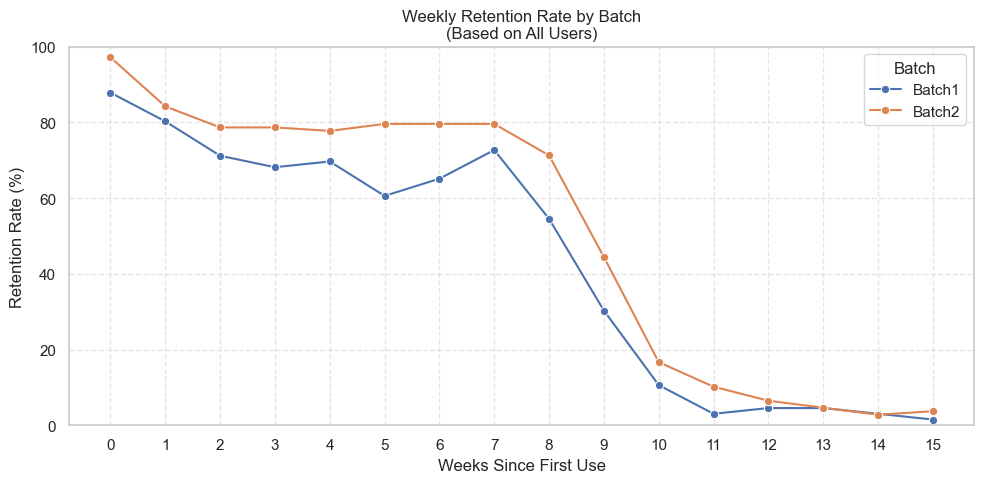

In [49]:
# ─── (A) 배치별 전체 사용자 목록을 따로 구하기 ─────────────────────────────
#    예: 디스크에 있는 폴더 이름을 그대로 사용
import os
from pathlib import Path

BASE_PATH = Path("/Users/yooseohyeon/Desktop/170325/eva_250121_processed")
batches = ["Batch1","Batch2"]

cohort_users = {}
for batch in batches:
    user_dirs = [d.name for d in (BASE_PATH/batch).glob("cmp1_usr*") if d.is_dir()]
    cohort_users[batch] = user_dirs

# 배치별 코호트 크기
cohort_sizes = {batch: len(uids) for batch, uids in cohort_users.items()}


# ─── (B) 기존 retention 코드에서 cohort_sizes 덮어쓰기 ────────────────────────
#    (interaction_df, week_offset 계산 등은 이미 끝났다는 가정)

retention_weekly = (
    interaction_df[['batch','user_id','week_offset']]
    .drop_duplicates()
    .groupby(['batch','week_offset'])['user_id']
    .nunique()
    .reset_index(name='retained_users')
)

# (변경!) 배치별 전체 등록자 수를 사용
retention_weekly['cohort_size'] = retention_weekly['batch'].map(cohort_sizes)

retention_weekly['retention_rate (%)'] = (
    retention_weekly['retained_users'] 
    / retention_weekly['cohort_size'] 
    * 100
)

# ─── (C) 시각화 ─────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns

MAX_WEEK = 15
df_plot = retention_weekly[retention_weekly['week_offset']<=MAX_WEEK]

plt.figure(figsize=(10,5))
sns.lineplot(
    df_plot, x='week_offset', y='retention_rate (%)',
    hue='batch', marker='o'
)
plt.title('Weekly Retention Rate by Batch\n(Based on All Users)')
plt.xlabel('Weeks Since First Use')
plt.ylabel('Retention Rate (%)')
plt.xticks(range(0, MAX_WEEK+1))
plt.ylim(0,100)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Batch')
plt.tight_layout()
plt.show()

In [50]:
# 🔹 주차별 리텐션 테이블 pivot 형태로 변환
weekly_table = retention_weekly.pivot(index='week_offset', columns='batch', values='retention_rate (%)')

# 🔹 소수점 한 자리로 정리
weekly_table = weekly_table.round(1)

# 🔹 결측값(예: Batch1만 있는 주차 등)은 0으로 채움 (선택)
weekly_table = weekly_table.fillna(0)

# 🔹 인덱스 이름 정리 (선택)
weekly_table.index.name = 'Week'
weekly_table.columns.name = 'Batch'
print("📋 Weekly Retention Rate Table (Batch1 vs Batch2):")
print(weekly_table)

weekly_table.to_csv(output_dir / "weekly_retention_table_by_batch.csv")

📋 Weekly Retention Rate Table (Batch1 vs Batch2):
Batch  Batch1  Batch2
Week                 
0        87.9    97.2
1        80.3    84.3
2        71.2    78.7
3        68.2    78.7
4        69.7    77.8
5        60.6    79.6
6        65.2    79.6
7        72.7    79.6
8        54.5    71.3
9        30.3    44.4
10       10.6    16.7
11        3.0    10.2
12        4.5     6.5
13        4.5     4.6
14        3.0     2.8
15        1.5     3.7
16        3.0     1.9
17        3.0     0.9
18        3.0     0.9
19        1.5     0.9
20        1.5     0.0
21        1.5     0.0
22        1.5     0.0
23        1.5     0.0
24        1.5     0.0
25        1.5     0.0
26        1.5     0.0
27        1.5     0.0


### App Events (source_20)

#### 디지털 습관 변화: 주별 앱 사용량 추세

Loading Batch2: 100%|██████████| 108/108 [00:03<00:00, 28.96it/s]


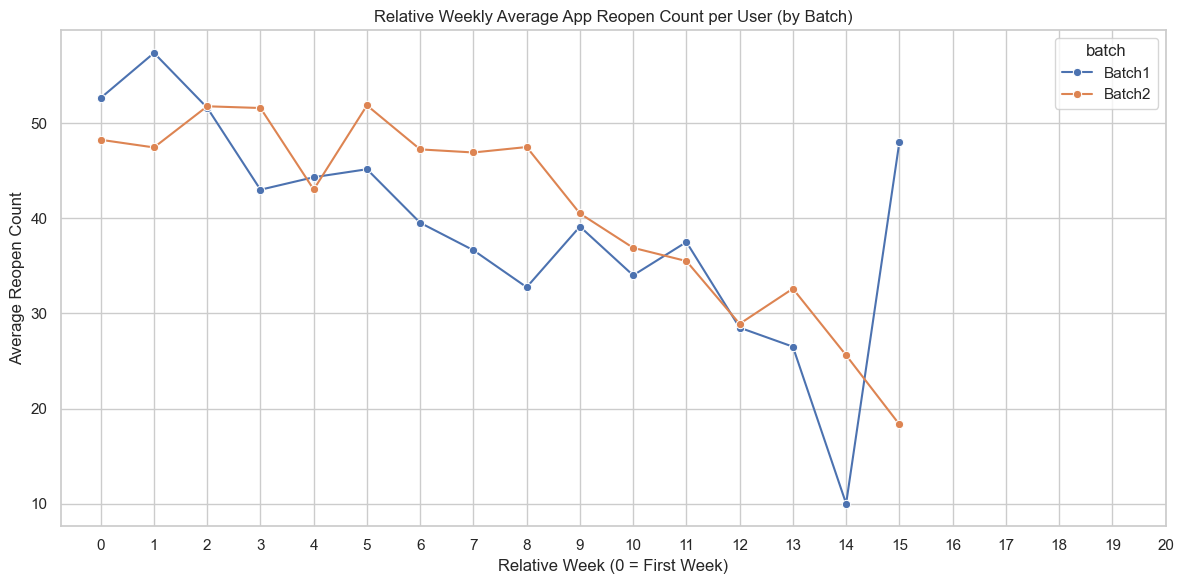

In [67]:
import pandas as pd
import json
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# ─── 설정 ─────────────────────────────────────────────
base_path = Path("/Users/yooseohyeon/Desktop/170325/eva_250121_processed")
output_dir = Path("./analysis_outputs")
output_dir.mkdir(exist_ok=True, parents=True)
sns.set(style="whitegrid")

def parse_value(val):
    try:
        val = val.replace("'", '"')
        return json.loads(val)
    except:
        return None

# ─── 1. source 20 데이터 불러오기 ─────────────────────
all_data = []
for batch in ["Batch1", "Batch2"]:
    user_dirs = list((base_path / batch).glob("cmp1_usr*"))
    for user_dir in tqdm(user_dirs, desc=f"Loading {batch}"):
        user_id = int(user_dir.name.replace("cmp1_usr", ""))
        file_path = user_dir / "source_20" / "data_source_20.csv"
        if not file_path.exists():
            continue
        df = pd.read_csv(file_path)
        df["parsed"] = df["value"].apply(parse_value)
        df["packageName"] = df["parsed"].apply(lambda x: x.get("packageName") if isinstance(x, dict) else None)
        df["activityType"] = df["parsed"].apply(lambda x: x.get("activityType") if isinstance(x, dict) else None)
        df["event_ts"] = pd.to_datetime(df["parsed"].apply(lambda x: x.get("timestamp") if isinstance(x, dict) else None))
        df["batch"] = batch
        df["user_id"] = user_id
        all_data.append(df[["batch", "user_id", "event_ts", "packageName", "activityType"]])

df = pd.concat(all_data, ignore_index=True)
df = df.dropna(subset=["event_ts", "packageName", "activityType"])
df = df.sort_values(by=["user_id", "packageName", "event_ts"]).reset_index(drop=True)

# ─── 2. reopen 판단 ──────────────────────────────────
df["prev_activity"] = df.groupby(["user_id", "packageName"])["activityType"].shift(1)

def is_reopen(row):
    return (
        row["activityType"] == "ACTIVITY_RESUMED - 1"
        and row["prev_activity"] in ["ACTIVITY_STOPPED - 23", "FOREGROUND_STOP - 20"]
    )

df["is_reopen"] = df.apply(is_reopen, axis=1)

# ─── 3. 사용자별 상대 주차 계산 ───────────────────────
first_day = df.groupby("user_id")["event_ts"].min().reset_index(name="first_day")
df = df.merge(first_day, on="user_id", how="left")
df["week_offset"] = ((df["event_ts"] - df["first_day"]).dt.days // 7).astype(int)

# ─── 4. 주차별 유저당 reopen 수 집계 ─────────────────
weekly_reopens = (
    df[df["is_reopen"]]
    .groupby(["batch", "user_id", "week_offset"])
    .size()
    .reset_index(name="reopen_count")
)

# ─── 5. 주차별 평균값 계산 ───────────────────────────
weekly_avg = (
    weekly_reopens
    .groupby(["batch", "week_offset"])["reopen_count"]
    .mean()
    .reset_index(name="avg_reopen_per_user")
)

# 주차 제한 (ex. 0~20주)
weekly_avg = weekly_avg[weekly_avg["week_offset"] <= 15]

# ─── 6. 시각화 ───────────────────────────────────────
plt.figure(figsize=(12, 6))
sns.lineplot(data=weekly_avg, x="week_offset", y="avg_reopen_per_user", hue="batch", marker="o")
plt.title("Relative Weekly Average App Reopen Count per User (by Batch)")
plt.xlabel("Relative Week (0 = First Week)")
plt.ylabel("Average Reopen Count")
plt.xticks(range(0, 21))
plt.grid(True)
plt.tight_layout()
plt.savefig(output_dir / "weekly_app_reopen_from_source20.png")
plt.show()

### 사용 앱 분석

In [ ]:
import pandas as pd
import json
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# ─── 설정 ─────────────────────────────────────────────
base_path = Path("/Users/yooseohyeon/Desktop/170325/eva_250121_processed")
output_dir = Path("./analysis_outputs")
output_dir.mkdir(exist_ok=True, parents=True)
sns.set(style="whitegrid")

# ✅ 0. 이탈자 리스트 (예시, 실제 리스트로 대체)
dropout_user_ids_batch1 = [542,584,597,601,608,613,617,618,621,631,639,645]
dropout_user_ids_batch2 = [662,663,666,669,682,683,689,701,704,716,723,725,726,727,736,746,756,765,767,769]

# ─── 1. source 20 데이터 로드 ──────────────────────────
def parse_value(val):
    try:
        val = val.replace("'", '"')
        return json.loads(val)
    except:
        return None

all_data = []
for batch in ["Batch1", "Batch2"]:
    user_dirs = list((base_path / batch).glob("cmp1_usr*"))
    for user_dir in tqdm(user_dirs, desc=f"Loading {batch}"):
        user_id = int(user_dir.name.replace("cmp1_usr", ""))
        file_path = user_dir / "source_20" / "data_source_20.csv"
        if not file_path.exists():
            continue
        df = pd.read_csv(file_path)
        df["parsed"] = df["value"].apply(parse_value)
        df["packageName"] = df["parsed"].apply(lambda x: x.get("packageName") if isinstance(x, dict) else None)
        df["event_ts"] = pd.to_datetime(df["parsed"].apply(lambda x: x.get("timestamp") if isinstance(x, dict) else None))
        df["batch"] = batch
        df["user_id"] = user_id
        all_data.append(df[["batch", "user_id", "event_ts", "packageName"]])

df = pd.concat(all_data, ignore_index=True).dropna(subset=["event_ts", "packageName"])

# ─── 2. top 10 앱만 카테고리 매핑 ─────────────────────
top_apps = df["packageName"].value_counts().head(10).index.tolist()
package_to_category = {
    "com.kakao.talk": "Social communication",
    "com.sec.android.app.launcher": "Launcher",
    "com.samsung.android.messaging": "Social communication",
    "com.cashwalk.cashwalk": "Health",
    "com.nhn.android.search": "Search",
    "com.shcard.smartpay": "Finance",
    "com.hyundai.oneapp.kr": "Utilities",
    "com.samsung.android.incallui": "Phone",
    "com.kbbank.kbbank": "Finance",
    "com.instagram.android": "Social communication"
}
df = df[df["packageName"].isin(top_apps)]
df["category"] = df["packageName"].map(package_to_category)

# ─── 3. 사용자별 상대 주차 계산 ────────────────────────
first_day = df.groupby("user_id")["event_ts"].min().reset_index(name="first_day")
df = df.merge(first_day, on="user_id", how="left")
df["week_offset"] = ((df["event_ts"] - df["first_day"]).dt.days // 7).astype(int)

# ─── 4. 카테고리별 사용자-주차 이벤트 수 ───────────────
category_weekly = (
    df.groupby(["batch", "user_id", "week_offset", "category"])
    .size()
    .reset_index(name="event_count")
)

# ─── 5. dropout 여부 추가 ─────────────────────────────
def get_dropout_flag(row):
    if row["batch"] == "Batch1":
        return row["user_id"] in dropout_user_ids_batch1
    elif row["batch"] == "Batch2":
        return row["user_id"] in dropout_user_ids_batch2
    return False

category_weekly["is_dropout"] = category_weekly.apply(get_dropout_flag, axis=1)

# ─── 6. 주별 평균 이벤트 수 계산 ──────────────────────
weekly_avg = (
    category_weekly
    .groupby(["batch", "is_dropout", "week_offset", "category"])["event_count"]
    .mean()
    .reset_index(name="avg_event_count")
)

# 주차 필터링 (예: 20주까지)


Loading Batch2: 100%|██████████| 108/108 [00:03<00:00, 30.71it/s]


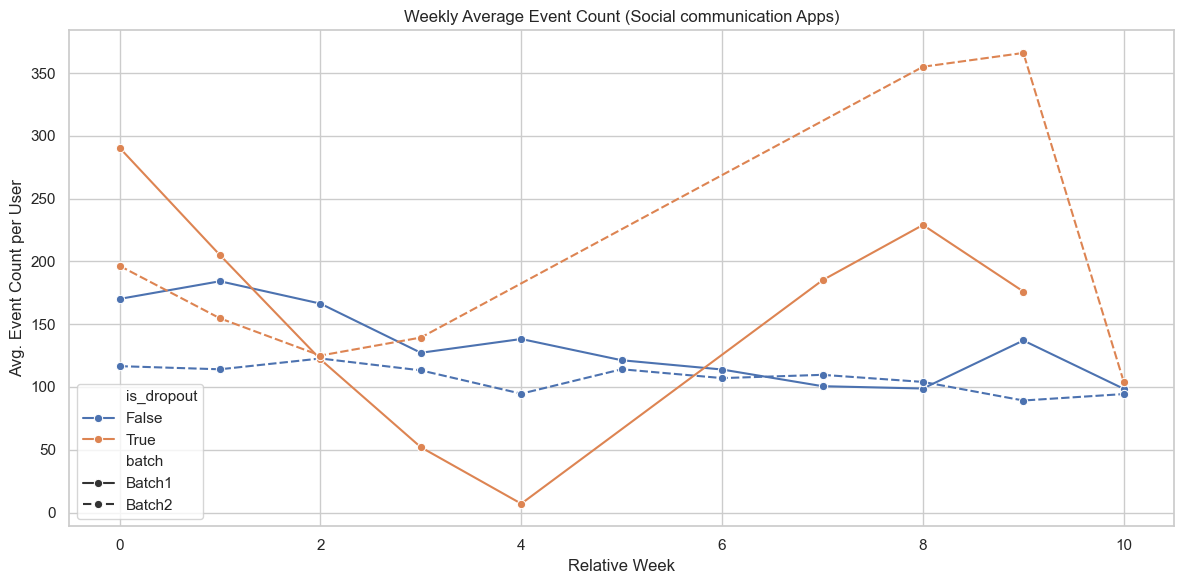

In [88]:
weekly_avg = weekly_avg[weekly_avg["week_offset"] <= 10]
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=weekly_avg[weekly_avg["category"] == "Social communication"],
    x="week_offset",
    y="avg_event_count",
    hue="is_dropout",
    style="batch",
    marker="o"
)
plt.title("Weekly Average Event Count (Social communication Apps)")
plt.xlabel("Relative Week")
plt.ylabel("Avg. Event Count per User")
plt.grid(True)
plt.tight_layout()
plt.savefig(output_dir / "weekly_avg_social_events_by_dropout.png")
plt.show()

Loading Batch2: 100%|██████████| 108/108 [00:03<00:00, 30.38it/s]


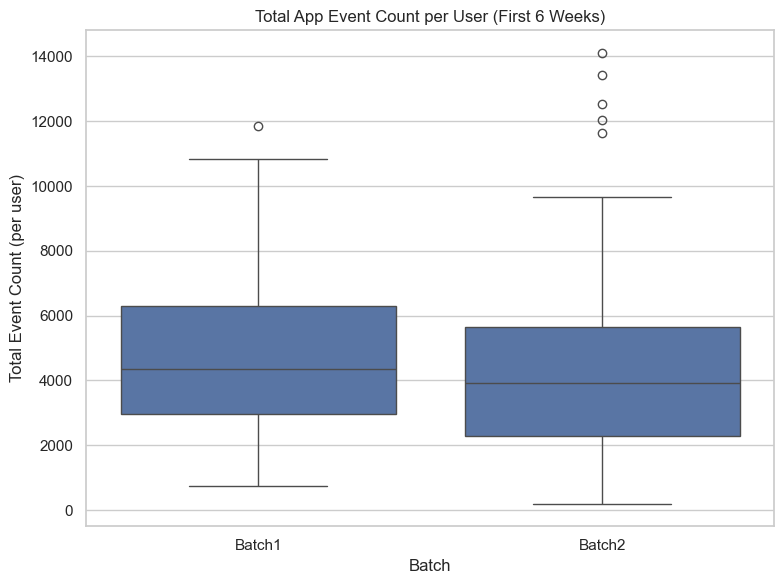

In [91]:
import pandas as pd
import json
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# ─── 설정 ─────────────────────────────────────────────
base_path = Path("/Users/yooseohyeon/Desktop/170325/eva_250121_processed")
output_dir = Path("./analysis_outputs")
output_dir.mkdir(exist_ok=True, parents=True)
sns.set(style="whitegrid")

# ─── 데이터 불러오기 ──────────────────────────────────
def parse_value(val):
    try:
        val = val.replace("'", '"')
        return json.loads(val)
    except:
        return None

all_data = []
for batch in ["Batch1", "Batch2"]:
    user_dirs = list((base_path / batch).glob("cmp1_usr*"))
    for user_dir in tqdm(user_dirs, desc=f"Loading {batch}"):
        user_id = int(user_dir.name.replace("cmp1_usr", ""))
        file_path = user_dir / "source_20" / "data_source_20.csv"
        if not file_path.exists():
            continue
        df = pd.read_csv(file_path)
        df["parsed"] = df["value"].apply(parse_value)
        df["packageName"] = df["parsed"].apply(lambda x: x.get("packageName") if isinstance(x, dict) else None)
        df["event_ts"] = pd.to_datetime(df["parsed"].apply(lambda x: x.get("timestamp") if isinstance(x, dict) else None))
        df["batch"] = batch
        df["user_id"] = user_id
        all_data.append(df[["batch", "user_id", "event_ts", "packageName"]])

df = pd.concat(all_data, ignore_index=True).dropna(subset=["event_ts", "packageName"])

# ─── 사용자별 상대 주차 계산 ───────────────────────────
first_day = df.groupby("user_id")["event_ts"].min().reset_index(name="first_day")
df = df.merge(first_day, on="user_id", how="left")
df["week_offset"] = ((df["event_ts"] - df["first_day"]).dt.days // 7).astype(int)

# ─── 첫 6주 필터링 ─────────────────────────────────────
df_6weeks = df[df["week_offset"] <= 5]

# ─── 사용자별 전체 앱 사용량 평균 계산 ────────────────
user_avg_usage = (
    df_6weeks
    .groupby(["batch", "user_id"])
    .size()
    .reset_index(name="total_event_count")
)

# ─── Boxplot 시각화 ────────────────────────────────────
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=user_avg_usage,
    x="batch",
    y="total_event_count"
)
plt.title("Total App Event Count per User (First 6 Weeks)")
plt.xlabel("Batch")
plt.ylabel("Total Event Count (per user)")
plt.tight_layout()
plt.savefig(output_dir / "boxplot_total_usage_by_batch.png")
plt.show()

Loading Batch2: 100%|██████████| 108/108 [00:03<00:00, 30.01it/s]
/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_41051/1154055698.py:70: UserWarning: Glyph 128241 (\N{MOBILE PHONE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_41051/1154055698.py:71: UserWarning: Glyph 128241 (\N{MOBILE PHONE}) missing from font(s) Arial.
  plt.savefig(output_dir / "boxplot_resume_event_by_batch.png")
/opt/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128241 (\N{MOBILE PHONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


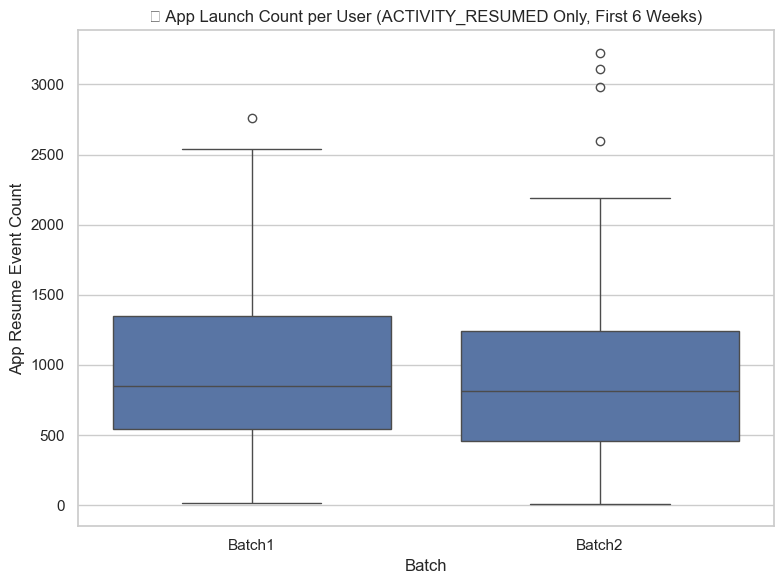

In [ ]:
import pandas as pd
import json
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# ─── 설정 ─────────────────────────────────────────────
base_path = Path("/Users/yooseohyeon/Desktop/170325/eva_250121_processed")
output_dir = Path("./analysis_outputs")
output_dir.mkdir(exist_ok=True, parents=True)
sns.set(style="whitegrid")

# ─── 데이터 불러오기 ──────────────────────────────────
def parse_value(val):
    try:
        val = val.replace("'", '"')
        return json.loads(val)
    except:
        return None

all_data = []
for batch in ["Batch1", "Batch2"]:
    user_dirs = list((base_path / batch).glob("cmp1_usr*"))
    for user_dir in tqdm(user_dirs, desc=f"Loading {batch}"):
        user_id = int(user_dir.name.replace("cmp1_usr", ""))
        file_path = user_dir / "source_20" / "data_source_20.csv"
        if not file_path.exists():
            continue
        df = pd.read_csv(file_path)
        df["parsed"] = df["value"].apply(parse_value)
        df["packageName"] = df["parsed"].apply(lambda x: x.get("packageName") if isinstance(x, dict) else None)
        df["activityType"] = df["parsed"].apply(lambda x: x.get("activityType") if isinstance(x, dict) else None)
        df["event_ts"] = pd.to_datetime(df["parsed"].apply(lambda x: x.get("timestamp") if isinstance(x, dict) else None))
        df["batch"] = batch
        df["user_id"] = user_id
        all_data.append(df[["batch", "user_id", "event_ts", "packageName", "activityType"]])

df = pd.concat(all_data, ignore_index=True).dropna(subset=["event_ts", "packageName", "activityType"])

# ─── 사용자별 상대 주차 계산 ───────────────────────────
first_day = df.groupby("user_id")["event_ts"].min().reset_index(name="first_day")
df = df.merge(first_day, on="user_id", how="left")
df["week_offset"] = ((df["event_ts"] - df["first_day"]).dt.days // 7).astype(int)

# ─── 6주 이내 필터 + ACTIVITY_RESUMED만 사용 ───────────
df_resumed = df[
    (df["week_offset"] <= 5) &
    (df["activityType"] == "ACTIVITY_RESUMED - 1")
]

# ─── 사용자별 실행 횟수 집계 ───────────────────────────
user_launch_count = (
    df_resumed
    .groupby(["batch", "user_id"])
    .size()
    .reset_index(name="resumed_count")
)

# ─── 박스플롯 시각화 ────────────────────────────────────
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=user_launch_count,
    x="batch",
    y="resumed_count"
)
plt.title("App Launch Count per User (ACTIVITY_RESUMED Only, First 6 Weeks)")
plt.xlabel("Batch")
plt.ylabel("App Resume Event Count")
plt.tight_layout()
plt.savefig(output_dir / "boxplot_resume_event_by_batch.png")
plt.show()